
## RNN for data with time delays


In [1]:

import pandas as pd
import numpy as np


In [2]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [3]:

import matplotlib 
## import pytorch_lightning as pl
import torch 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


In [4]:

## Requires Python = 3.9



## Parameters


In [5]:

window                 = 3    ## 90   ## 30          ## seq length

silicon_feature_index  = 0

avg_the_rows_parameter =  1   ##   15

vector_n_out = 26


## 1    ->  1 minute time step
## 15   -> 15 minute time step
## 1440 -> 24 hour time step
## 480  -> 8 hour shift
## 60   -> 1 hour time step



## Read the data


In [6]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [7]:

for_RNN_data_CIVS.head(5)


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0           1  0.655900                4.242439          2161.425209   
1           2  0.608500                4.250658          2155.622815   
2           3  0.575508                4.257849          2150.390786   
3           4  0.719500                4.133909          2167.094817   
4           5  0.710486                4.174343          2168.238915   

   NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0            9306.840913   184.818611                    0.0           0.0   
1            9317.204202   185.000295                    0.0           0.0   
2            9379.027265   184.611966                    0.0           0.0   
3            9442.367486   185.744793                    0.0           0.0   
4            9336.364456   185.993447                    0.0           0.0   

   Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SW_Uptake_f3  HOT_METAL_TEMP_f3  \
0           0.354        0.16  ...    192.512412        2730.002686   
1           0.323        0.00  ...    221.646579        2730.002686   
2           0.330        0.00  ...    207.505852        2730.002686   
3           0.345        0.00  ...    201.510393        2727.202379   
4           0.313        0.83  ...    192.366046        2730.002686   

    HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0  2726.666667     37.369999    36.439999         9.86   
1  2727.400000      0.000000     0.000000         0.00   
2  2690.500000      0.000000     0.000000         0.00   
3  2681.192953      0.000000     0.000000         0.00   
4  2724.225000     35.540001    35.970001         9.03   

   SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  Coke_Rate_f3  
0                98.334297     18.532928              36.602600         884.0  
1                98.334297     18.275620              36.601051         884.0  
2                98.334297     18.134174              36.599696         884.0  
3                98.334297     18.378320              36.262273         884.0  
4                98.334297     18.397217              36.882963         884.0  

[5 rows x 27 columns]

In [8]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.655900                4.242439          2161.425209   
1              2  0.608500                4.250658          2155.622815   
2              3  0.575508                4.257849          2150.390786   
3              4  0.719500                4.133909          2167.094817   
4              5  0.710486                4.174343          2168.238915   
...          ...       ...                     ...                  ...   
1590        1591  0.646000                4.208539          2169.079601   
1591        1592  0.654667                4.212648          2168.797556   
1592        1593  0.591667                4.217784          2168.444999   
1593        1594  0.724667                4.223948          2167.967389   
1594        1595  0.628625                4.230112          2166.628469   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9317.204202   185.000295                    0.0           0.0   
2               9379.027265   184.611966                    0.0           0.0   
3               9442.367486   185.744793                    0.0           0.0   
4               9336.364456   185.993447                    0.0           0.0   
...                     ...          ...                    ...           ...   
1590            9312.779010   185.053796                    0.0           0.0   
1591            9303.753420   185.007919                    0.0           0.0   
1592            9333.448101   184.942435                    0.0           0.0   
1593            9321.819731   184.863855                    0.0           0.0   
1594            9293.853451   184.785275                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SW_Uptake_f3  HOT_METAL_TEMP_f3  \
0              0.354        0.16  ...    192.512412        2730.002686   
1              0.323        0.00  ...    221.646579        2730.002686   
2              0.330        0.00  ...    207.505852        2730.002686   
3              0.345        0.00  ...    201.510393        2727.202379   
4              0.313        0.83  ...    192.366046        2730.002686   
...              ...         ...  ...           ...                ...   
1590           0.324        0.30  ...    193.501805        2730.002686   
1591           0.325        0.16  ...    194.328694        2730.002686   
1592           0.335        0.26  ...    215.606202        2730.002686   
1593           0.328        1.08  ...    250.937261        2730.002686   
1594           0.342        0.19  ...    184.739374        2730.002686   

       HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0     2726.666667     37.369999    36.439999         9.86   
1     2727.400000      0.000000     0.000000         0.00   
2     2690.500000      0.000000     0.000000         0.00   
3     2681.192953      0.000000     0.000000         0.00   
4     2724.225000     35.540001    35.970001         9.03   
...           ...           ...          ...          ...   
1590  2739.000000     35.900002    37.259998        10.04   
1591  2710.500000     35.580002    36.500000         9.30   
1592  2750.000000     35.130001    37.470001        10.01   
1593  2678.333333     35.570000    36.970001         9.47   
1594  2725.333333     36.180000    35.810001         9.22   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.275620              36.601051   
2                   98.334297     18.134174              36.599696   
3                   98.334297     18.378320              36.262273   
4                   98.334297     18.397217              36.882963   
...                       ...           ...                    ...   
1590                

In [9]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'HOT_METAL_TEMP_f3',
 'HM_Temp_f1',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'Coke_Rate_f3']

In [10]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'HOT_METAL_TEMP_f3',
 'HM_Temp_f1',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'Coke_Rate_f3']


In [11]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [12]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.655900                4.242439          2161.425209   
1     0.608500                4.250658          2155.622815   
2     0.575508                4.257849          2150.390786   
3     0.719500                4.133909          2167.094817   
4     0.710486                4.174343          2168.238915   
...        ...                     ...                  ...   
1590  0.646000                4.208539          2169.079601   
1591  0.654667                4.212648          2168.797556   
1592  0.591667                4.217784          2168.444999   
1593  0.724667                4.223948          2167.967389   
1594  0.628625                4.230112          2166.628469   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9317.204202   185.000295                    0.0           0.0   
2               9379.027265   184.611966                    0.0           0.0   
3               9442.367486   185.744793                    0.0           0.0   
4               9336.364456   185.993447                    0.0           0.0   
...                     ...          ...                    ...           ...   
1590            9312.779010   185.053796                    0.0           0.0   
1591            9303.753420   185.007919                    0.0           0.0   
1592            9333.448101   184.942435                    0.0           0.0   
1593            9321.819731   184.863855                    0.0           0.0   
1594            9293.853451   184.785275                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SW_Uptake_f3  \
0              0.354        0.16            21.080431  ...    192.512412   
1              0.323        0.00            21.089264  ...    221.646579   
2              0.330        0.00            21.096992  ...    207.505852   
3              0.345        0.00            20.670933  ...    201.510393   
4              0.313        0.83            20.996415  ...    192.366046   
...              ...         ...                  ...  ...           ...   
1590           0.324        0.30            21.043999  ...    193.501805   
1591           0.325        0.16            21.048415  ...    194.328694   
1592           0.335        0.26            21.053935  ...    215.606202   
1593           0.328        1.08            21.060559  ...    250.937261   
1594           0.342        0.19            21.067183  ...    184.739374   

      HOT_METAL_TEMP_f3   HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0           2730.002686  2726.666667     37.369999    36.439999         9.86   
1           2730.002686  2727.400000      0.000000     0.000000         0.00   
2           2730.002686  2690.500000      0.000000     0.000000         0.00   
3           2727.202379  2681.192953      0.000000     0.000000         0.00   
4           2730.002686  2724.225000     35.540001    35.970001         9.03   
...                 ...          ...           ...          ...          ...   
1590        2730.002686  2739.000000     35.900002    37.259998        10.04   
1591        2730.002686  2710.500000     35.580002    36.500000         9.30   
1592        2730.002686  2750.000000     35.130001    37.470001        10.01   
1593        2730.002686  2678.333333     35.570000    36.970001         9.47   
1594        2730.002686  2725.333333     36.180000    35.810001         9.22   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.275620              36.601051   
2                   98.334297     18.134174              36.599696   
3                   98.334297     18.378320              36.262273   
4                   98.334297     18.397217            

In [13]:

for_RNN_data_CIVS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SI_f1                    1595 non-null   float64
 1   HOST_BLAST_MOISTURE_f3   1595 non-null   float64
 2   HOT_BLAST_TMP_NS_f3      1595 non-null   float64
 3   NAT_GAS _INJECTION_f3    1595 non-null   float64
 4   WINDRATE_f3              1595 non-null   float64
 5   HIGH_PURITY_OXYGEN_f3    1595 non-null   float64
 6   COAL_FLOW_f3             1595 non-null   float64
 7   Cast_Avg_Mn_f2           1595 non-null   float64
 8   Slag_Fe_f2               1595 non-null   float64
 9   Selec_Top_Gas_CO_f3      1595 non-null   float64
 10  Selec_Top_Gas_CO2_f3     1595 non-null   float64
 11  Selec_Top_Gas_H2_f3      1595 non-null   float64
 12  Selec_Top_Gas_N2_f3      1595 non-null   float64
 13  NE_Uptake_f3             1595 non-null   float64
 14  SE_Uptake_f3            


## Plots


In [14]:
'''
for_RNN_data_CIVS['MM_Timestamp_f1'] = for_RNN_data_CIVS['MM_Timestamp_f1'].astype("datetime64[ns]")

rc22 = for_RNN_data_CIVS['MM_Timestamp_f1'].astype("datetime64[ns]")
'''

'\nfor_RNN_data_CIVS[\'MM_Timestamp_f1\'] = for_RNN_data_CIVS[\'MM_Timestamp_f1\'].astype("datetime64[ns]")\n\nrc22 = for_RNN_data_CIVS[\'MM_Timestamp_f1\'].astype("datetime64[ns]")\n'

In [15]:

##rc22


In [16]:

plt.rcParams["figure.figsize"] = [15, 5]


In [17]:

## plt.plot(rc22, for_RNN_data_CIVS['SI_f1'])


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

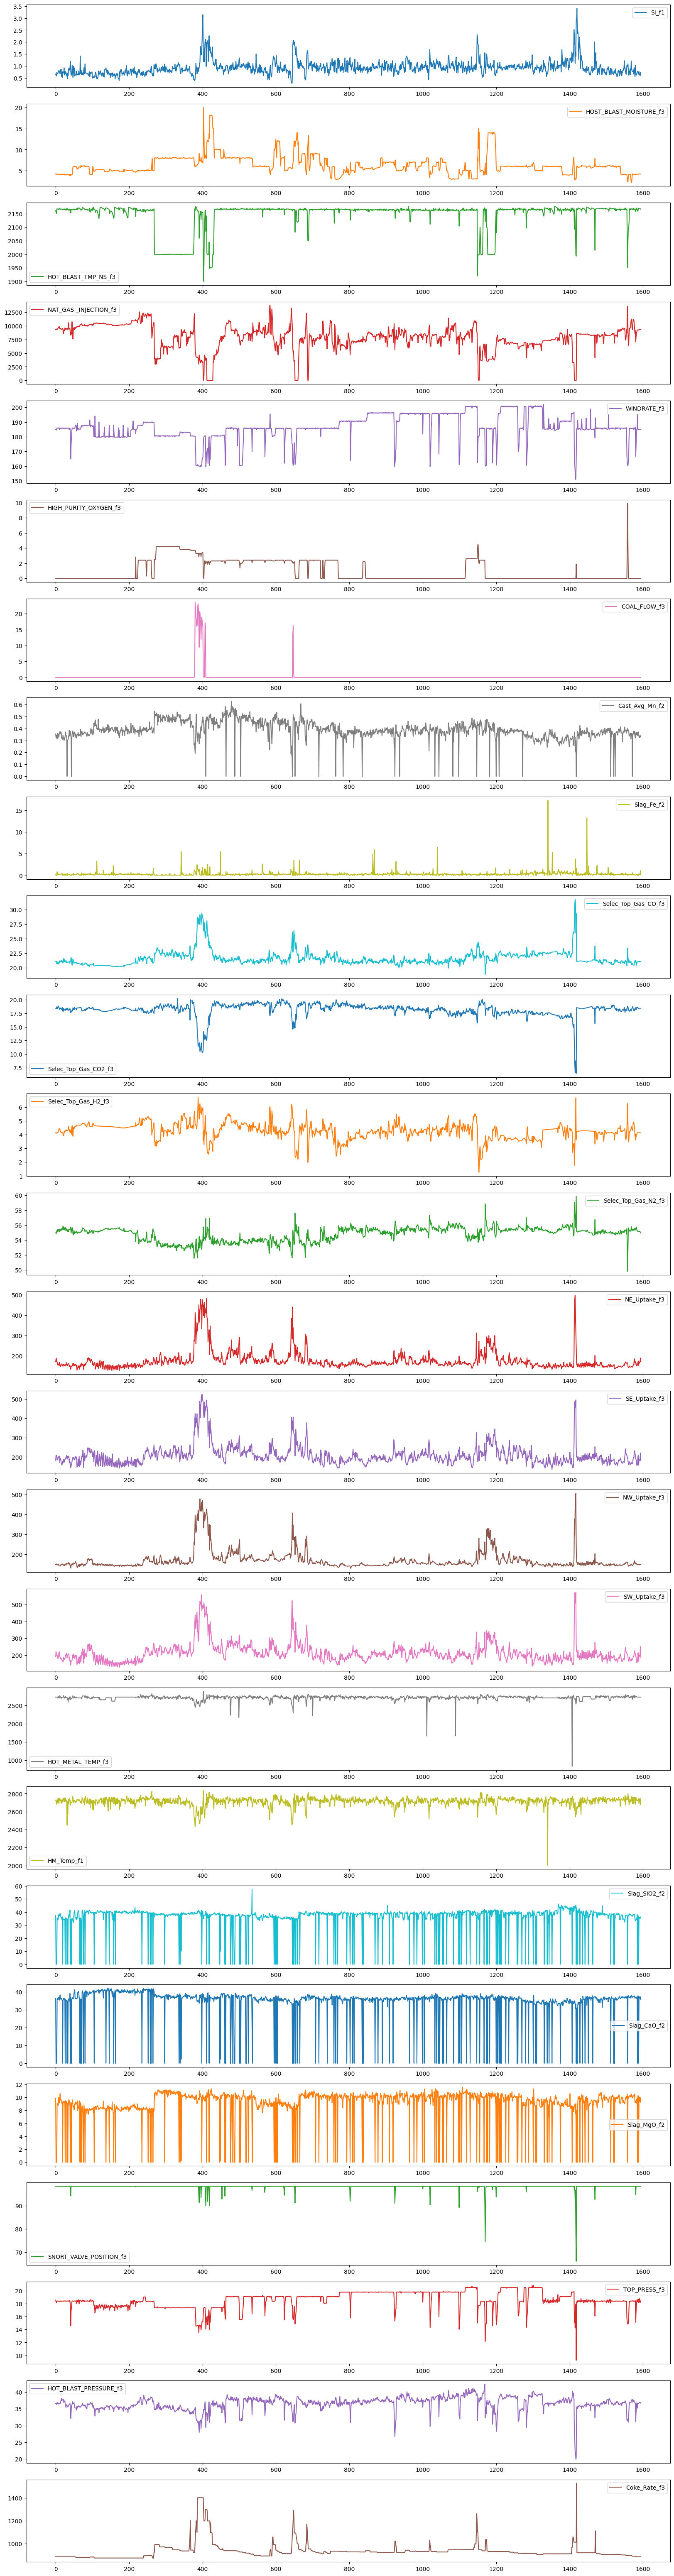

In [18]:

## layout=(4, 3), 
## style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
## xticks=np.arange(0, len(df), 16)

## for_RNN_data_CIVS.plot( xticks=rc22, figsize=(20,80),  subplots=True   )

## x='MM_Timestamp_f1' ,

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [19]:

l_new


['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'HOT_METAL_TEMP_f3',
 'HM_Temp_f1',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'Coke_Rate_f3']


## Back to the Data Processing


In [20]:

for_RNN_data_CIVS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SI_f1                    1595 non-null   float64
 1   HOST_BLAST_MOISTURE_f3   1595 non-null   float64
 2   HOT_BLAST_TMP_NS_f3      1595 non-null   float64
 3   NAT_GAS _INJECTION_f3    1595 non-null   float64
 4   WINDRATE_f3              1595 non-null   float64
 5   HIGH_PURITY_OXYGEN_f3    1595 non-null   float64
 6   COAL_FLOW_f3             1595 non-null   float64
 7   Cast_Avg_Mn_f2           1595 non-null   float64
 8   Slag_Fe_f2               1595 non-null   float64
 9   Selec_Top_Gas_CO_f3      1595 non-null   float64
 10  Selec_Top_Gas_CO2_f3     1595 non-null   float64
 11  Selec_Top_Gas_H2_f3      1595 non-null   float64
 12  Selec_Top_Gas_N2_f3      1595 non-null   float64
 13  NE_Uptake_f3             1595 non-null   float64
 14  SE_Uptake_f3            

In [21]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.655900                4.242439          2161.425209   
1     0.608500                4.250658          2155.622815   
2     0.575508                4.257849          2150.390786   
3     0.719500                4.133909          2167.094817   
4     0.710486                4.174343          2168.238915   
...        ...                     ...                  ...   
1590  0.646000                4.208539          2169.079601   
1591  0.654667                4.212648          2168.797556   
1592  0.591667                4.217784          2168.444999   
1593  0.724667                4.223948          2167.967389   
1594  0.628625                4.230112          2166.628469   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9317.204202   185.000295                    0.0           0.0   
2               9379.027265   184.611966                    0.0           0.0   
3               9442.367486   185.744793                    0.0           0.0   
4               9336.364456   185.993447                    0.0           0.0   
...                     ...          ...                    ...           ...   
1590            9312.779010   185.053796                    0.0           0.0   
1591            9303.753420   185.007919                    0.0           0.0   
1592            9333.448101   184.942435                    0.0           0.0   
1593            9321.819731   184.863855                    0.0           0.0   
1594            9293.853451   184.785275                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SW_Uptake_f3  \
0              0.354        0.16            21.080431  ...    192.512412   
1              0.323        0.00            21.089264  ...    221.646579   
2              0.330        0.00            21.096992  ...    207.505852   
3              0.345        0.00            20.670933  ...    201.510393   
4              0.313        0.83            20.996415  ...    192.366046   
...              ...         ...                  ...  ...           ...   
1590           0.324        0.30            21.043999  ...    193.501805   
1591           0.325        0.16            21.048415  ...    194.328694   
1592           0.335        0.26            21.053935  ...    215.606202   
1593           0.328        1.08            21.060559  ...    250.937261   
1594           0.342        0.19            21.067183  ...    184.739374   

      HOT_METAL_TEMP_f3   HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0           2730.002686  2726.666667     37.369999    36.439999         9.86   
1           2730.002686  2727.400000      0.000000     0.000000         0.00   
2           2730.002686  2690.500000      0.000000     0.000000         0.00   
3           2727.202379  2681.192953      0.000000     0.000000         0.00   
4           2730.002686  2724.225000     35.540001    35.970001         9.03   
...                 ...          ...           ...          ...          ...   
1590        2730.002686  2739.000000     35.900002    37.259998        10.04   
1591        2730.002686  2710.500000     35.580002    36.500000         9.30   
1592        2730.002686  2750.000000     35.130001    37.470001        10.01   
1593        2730.002686  2678.333333     35.570000    36.970001         9.47   
1594        2730.002686  2725.333333     36.180000    35.810001         9.22   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.275620              36.601051   
2                   98.334297     18.134174              36.599696   
3                   98.334297     18.378320              36.262273   
4                   98.334297     18.397217            


## Iterate and mark transitions


In [22]:
'''
for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control1',
                                value = 0)


for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control4',
                                value = 0)


for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control2',
                                value = 0)


for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control3',
                                value = 0)



for_RNN_data_CIVS
'''

"\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control1',\n                                value = 0)\n\n\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control4',\n                                value = 0)\n\n\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control2',\n                                value = 0)\n\n\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control3',\n                                value = 0)\n\n\n\nfor_RNN_data_CIVS\n"

In [23]:
'''
indeces_to_2500_control2 = []

indeces_to_2500 = [] 

counter_control2 = 0

counter = 500

prev_val = 0.0
    
for index, row in for_RNN_data_CIVS.iterrows():

    ## print( row["SI_f1"]  )
    #########################################################################
    if row["SI_f1"] == prev_val:
        for_RNN_data_CIVS.at[index, 'control1'] = counter
        counter = counter + 1
        indeces_to_2500.append( index )
    else:
        if counter > 2000:
            ## print(counter)
            ## input()
            for_RNN_data_CIVS["control4"][indeces_to_2500 ] = 1
            indeces_to_2500 = []
        else:
            indeces_to_2500 = []
        counter = 0

    ##########################################################################
    if row["SI_f1"] != prev_val:
        for_RNN_data_CIVS.at[index, 'control2'] = counter_control2
        counter_control2 = counter_control2 + 1
        indeces_to_2500_control2.append(  index  )
    else:
        if counter_control2 > 2000:
            ## print(counter)
            ## input()
            for_RNN_data_CIVS["control4"][indeces_to_2500_control2 ] = 1
            indeces_to_2500_control2 = []
        else:
            indeces_to_2500_control2 = []
        counter_control2 = 0

    ##########################################################################
    if row["SI_f1"] == prev_val:
        for_RNN_data_CIVS.at[index, 'control3'] = 1.0

    ##########################################################################
    if index  % 50000 == 0:
        print(index )
    prev_val = row["SI_f1"]
        
    
'''
    


'\nindeces_to_2500_control2 = []\n\nindeces_to_2500 = [] \n\ncounter_control2 = 0\n\ncounter = 500\n\nprev_val = 0.0\n    \nfor index, row in for_RNN_data_CIVS.iterrows():\n\n    ## print( row["SI_f1"]  )\n    #########################################################################\n    if row["SI_f1"] == prev_val:\n        for_RNN_data_CIVS.at[index, \'control1\'] = counter\n        counter = counter + 1\n        indeces_to_2500.append( index )\n    else:\n        if counter > 2000:\n            ## print(counter)\n            ## input()\n            for_RNN_data_CIVS["control4"][indeces_to_2500 ] = 1\n            indeces_to_2500 = []\n        else:\n            indeces_to_2500 = []\n        counter = 0\n\n    ##########################################################################\n    if row["SI_f1"] != prev_val:\n        for_RNN_data_CIVS.at[index, \'control2\'] = counter_control2\n        counter_control2 = counter_control2 + 1\n        indeces_to_2500_control2.append(  index  )

In [24]:
'''
## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )


for_RNN_data_CIVS.plot(x='MM_Timestamp_f1' , kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )
'''

"\n## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )\n\n\nfor_RNN_data_CIVS.plot(x='MM_Timestamp_f1' , kind='line', subplots=True, figsize=(20,80),\n        sharex=False, sharey=False, legend=True )\n"

In [25]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.655900                4.242439          2161.425209   
1     0.608500                4.250658          2155.622815   
2     0.575508                4.257849          2150.390786   
3     0.719500                4.133909          2167.094817   
4     0.710486                4.174343          2168.238915   
...        ...                     ...                  ...   
1590  0.646000                4.208539          2169.079601   
1591  0.654667                4.212648          2168.797556   
1592  0.591667                4.217784          2168.444999   
1593  0.724667                4.223948          2167.967389   
1594  0.628625                4.230112          2166.628469   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9317.204202   185.000295                    0.0           0.0   
2               9379.027265   184.611966                    0.0           0.0   
3               9442.367486   185.744793                    0.0           0.0   
4               9336.364456   185.993447                    0.0           0.0   
...                     ...          ...                    ...           ...   
1590            9312.779010   185.053796                    0.0           0.0   
1591            9303.753420   185.007919                    0.0           0.0   
1592            9333.448101   184.942435                    0.0           0.0   
1593            9321.819731   184.863855                    0.0           0.0   
1594            9293.853451   184.785275                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SW_Uptake_f3  \
0              0.354        0.16            21.080431  ...    192.512412   
1              0.323        0.00            21.089264  ...    221.646579   
2              0.330        0.00            21.096992  ...    207.505852   
3              0.345        0.00            20.670933  ...    201.510393   
4              0.313        0.83            20.996415  ...    192.366046   
...              ...         ...                  ...  ...           ...   
1590           0.324        0.30            21.043999  ...    193.501805   
1591           0.325        0.16            21.048415  ...    194.328694   
1592           0.335        0.26            21.053935  ...    215.606202   
1593           0.328        1.08            21.060559  ...    250.937261   
1594           0.342        0.19            21.067183  ...    184.739374   

      HOT_METAL_TEMP_f3   HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0           2730.002686  2726.666667     37.369999    36.439999         9.86   
1           2730.002686  2727.400000      0.000000     0.000000         0.00   
2           2730.002686  2690.500000      0.000000     0.000000         0.00   
3           2727.202379  2681.192953      0.000000     0.000000         0.00   
4           2730.002686  2724.225000     35.540001    35.970001         9.03   
...                 ...          ...           ...          ...          ...   
1590        2730.002686  2739.000000     35.900002    37.259998        10.04   
1591        2730.002686  2710.500000     35.580002    36.500000         9.30   
1592        2730.002686  2750.000000     35.130001    37.470001        10.01   
1593        2730.002686  2678.333333     35.570000    36.970001         9.47   
1594        2730.002686  2725.333333     36.180000    35.810001         9.22   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.275620              36.601051   
2                   98.334297     18.134174              36.599696   
3                   98.334297     18.378320              36.262273   
4                   98.334297     18.397217            


## Drop row with value above x


In [26]:
'''
## for_RNN_data_CIVS = for_RNN_data_CIVS.drop( for_RNN_data_CIVS[ for_RNN_data_CIVS.control4 == 1 ].index ) ## , inplace = True)

for_RNN_data_CIVS = for_RNN_data_CIVS [ for_RNN_data_CIVS ["control4"] == 0].reset_index( drop=True )  ## this one
'''

'\n## for_RNN_data_CIVS = for_RNN_data_CIVS.drop( for_RNN_data_CIVS[ for_RNN_data_CIVS.control4 == 1 ].index ) ## , inplace = True)\n\nfor_RNN_data_CIVS = for_RNN_data_CIVS [ for_RNN_data_CIVS ["control4"] == 0].reset_index( drop=True )  ## this one\n'

In [27]:

## for_RNN_data_CIVS


In [28]:
'''
## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )
'''

"\n## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )\n\nfor_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),\n        sharex=False, sharey=False, legend=True )\n"

In [29]:

for_RNN_data_CIVS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SI_f1                    1595 non-null   float64
 1   HOST_BLAST_MOISTURE_f3   1595 non-null   float64
 2   HOT_BLAST_TMP_NS_f3      1595 non-null   float64
 3   NAT_GAS _INJECTION_f3    1595 non-null   float64
 4   WINDRATE_f3              1595 non-null   float64
 5   HIGH_PURITY_OXYGEN_f3    1595 non-null   float64
 6   COAL_FLOW_f3             1595 non-null   float64
 7   Cast_Avg_Mn_f2           1595 non-null   float64
 8   Slag_Fe_f2               1595 non-null   float64
 9   Selec_Top_Gas_CO_f3      1595 non-null   float64
 10  Selec_Top_Gas_CO2_f3     1595 non-null   float64
 11  Selec_Top_Gas_H2_f3      1595 non-null   float64
 12  Selec_Top_Gas_N2_f3      1595 non-null   float64
 13  NE_Uptake_f3             1595 non-null   float64
 14  SE_Uptake_f3            

In [30]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.655900                4.242439          2161.425209   
1     0.608500                4.250658          2155.622815   
2     0.575508                4.257849          2150.390786   
3     0.719500                4.133909          2167.094817   
4     0.710486                4.174343          2168.238915   
...        ...                     ...                  ...   
1590  0.646000                4.208539          2169.079601   
1591  0.654667                4.212648          2168.797556   
1592  0.591667                4.217784          2168.444999   
1593  0.724667                4.223948          2167.967389   
1594  0.628625                4.230112          2166.628469   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9317.204202   185.000295                    0.0           0.0   
2               9379.027265   184.611966                    0.0           0.0   
3               9442.367486   185.744793                    0.0           0.0   
4               9336.364456   185.993447                    0.0           0.0   
...                     ...          ...                    ...           ...   
1590            9312.779010   185.053796                    0.0           0.0   
1591            9303.753420   185.007919                    0.0           0.0   
1592            9333.448101   184.942435                    0.0           0.0   
1593            9321.819731   184.863855                    0.0           0.0   
1594            9293.853451   184.785275                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SW_Uptake_f3  \
0              0.354        0.16            21.080431  ...    192.512412   
1              0.323        0.00            21.089264  ...    221.646579   
2              0.330        0.00            21.096992  ...    207.505852   
3              0.345        0.00            20.670933  ...    201.510393   
4              0.313        0.83            20.996415  ...    192.366046   
...              ...         ...                  ...  ...           ...   
1590           0.324        0.30            21.043999  ...    193.501805   
1591           0.325        0.16            21.048415  ...    194.328694   
1592           0.335        0.26            21.053935  ...    215.606202   
1593           0.328        1.08            21.060559  ...    250.937261   
1594           0.342        0.19            21.067183  ...    184.739374   

      HOT_METAL_TEMP_f3   HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0           2730.002686  2726.666667     37.369999    36.439999         9.86   
1           2730.002686  2727.400000      0.000000     0.000000         0.00   
2           2730.002686  2690.500000      0.000000     0.000000         0.00   
3           2727.202379  2681.192953      0.000000     0.000000         0.00   
4           2730.002686  2724.225000     35.540001    35.970001         9.03   
...                 ...          ...           ...          ...          ...   
1590        2730.002686  2739.000000     35.900002    37.259998        10.04   
1591        2730.002686  2710.500000     35.580002    36.500000         9.30   
1592        2730.002686  2750.000000     35.130001    37.470001        10.01   
1593        2730.002686  2678.333333     35.570000    36.970001         9.47   
1594        2730.002686  2725.333333     36.180000    35.810001         9.22   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.275620              36.601051   
2                   98.334297     18.134174              36.599696   
3                   98.334297     18.378320              36.262273   
4                   98.334297     18.397217            


## Average the rows to control time step



## Sanity check


In [31]:



data = [
[20 , 9,   15,  47],
[2,   50,  25,  26],
[4,   11,  38,  44],
[6,   33,  16,  25],
[8 ,  37,  27,  25],
[10,  28,  48,  32],
[12,  47,  35,  45],
[14,  8,   16,  7],
[16,  12,  16,  30],
[18 , 22,  39 , 29],
[20 , 9,   15,  47],
[20 , 9,   15,  47],
[2,   50,  25,  26],
[4,   11,  38,  44],
[6,   33,  16,  25],
[8 ,  37,  27,  25],
[10,  28,  48,  32],
[12,  47,  35,  45],
[14,  8,   16,  7],
[16,  12,  16,  30],
[18 , 22,  39 , 29],
[20 , 9,   15,  47],
[2,   50,  25,  26],
[4,   11,  38,  44],
[6,   33,  16,  25],
[8 ,  37,  27,  25],
[10,  28,  48,  32],
[12,  47,  35,  45],
[14,  8,   16,  7],
[16,  12,  16,  30]
]



df_example = pd.DataFrame( data, columns=['a', 'b', 'c', 'd'] )
 

print(df_example)


     a   b   c   d
0   20   9  15  47
1    2  50  25  26
2    4  11  38  44
3    6  33  16  25
4    8  37  27  25
5   10  28  48  32
6   12  47  35  45
7   14   8  16   7
8   16  12  16  30
9   18  22  39  29
10  20   9  15  47
11  20   9  15  47
12   2  50  25  26
13   4  11  38  44
14   6  33  16  25
15   8  37  27  25
16  10  28  48  32
17  12  47  35  45
18  14   8  16   7
19  16  12  16  30
20  18  22  39  29
21  20   9  15  47
22   2  50  25  26
23   4  11  38  44
24   6  33  16  25
25   8  37  27  25
26  10  28  48  32
27  12  47  35  45
28  14   8  16   7
29  16  12  16  30


In [32]:

print(df_example.shape)


(30, 4)


In [33]:

## avg_df_example = df_example.groupby(np.arange(len(df_example))//avg_the_rows_parameter).mean()
## avg_df_example.shape


In [34]:

## avg_df_example



## Now Avg to change time step


In [35]:

## for_RNN_data_CIVS

print(for_RNN_data_CIVS.shape)


(1595, 26)


In [36]:
'''
for_RNN_data_CIVS = for_RNN_data_CIVS.groupby(np.arange(len(for_RNN_data_CIVS))//avg_the_rows_parameter).mean()
for_RNN_data_CIVS.shape
'''

'\nfor_RNN_data_CIVS = for_RNN_data_CIVS.groupby(np.arange(len(for_RNN_data_CIVS))//avg_the_rows_parameter).mean()\nfor_RNN_data_CIVS.shape\n'

In [37]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.655900                4.242439          2161.425209   
1     0.608500                4.250658          2155.622815   
2     0.575508                4.257849          2150.390786   
3     0.719500                4.133909          2167.094817   
4     0.710486                4.174343          2168.238915   
...        ...                     ...                  ...   
1590  0.646000                4.208539          2169.079601   
1591  0.654667                4.212648          2168.797556   
1592  0.591667                4.217784          2168.444999   
1593  0.724667                4.223948          2167.967389   
1594  0.628625                4.230112          2166.628469   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9317.204202   185.000295                    0.0           0.0   
2               9379.027265   184.611966                    0.0           0.0   
3               9442.367486   185.744793                    0.0           0.0   
4               9336.364456   185.993447                    0.0           0.0   
...                     ...          ...                    ...           ...   
1590            9312.779010   185.053796                    0.0           0.0   
1591            9303.753420   185.007919                    0.0           0.0   
1592            9333.448101   184.942435                    0.0           0.0   
1593            9321.819731   184.863855                    0.0           0.0   
1594            9293.853451   184.785275                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SW_Uptake_f3  \
0              0.354        0.16            21.080431  ...    192.512412   
1              0.323        0.00            21.089264  ...    221.646579   
2              0.330        0.00            21.096992  ...    207.505852   
3              0.345        0.00            20.670933  ...    201.510393   
4              0.313        0.83            20.996415  ...    192.366046   
...              ...         ...                  ...  ...           ...   
1590           0.324        0.30            21.043999  ...    193.501805   
1591           0.325        0.16            21.048415  ...    194.328694   
1592           0.335        0.26            21.053935  ...    215.606202   
1593           0.328        1.08            21.060559  ...    250.937261   
1594           0.342        0.19            21.067183  ...    184.739374   

      HOT_METAL_TEMP_f3   HM_Temp_f1  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0           2730.002686  2726.666667     37.369999    36.439999         9.86   
1           2730.002686  2727.400000      0.000000     0.000000         0.00   
2           2730.002686  2690.500000      0.000000     0.000000         0.00   
3           2727.202379  2681.192953      0.000000     0.000000         0.00   
4           2730.002686  2724.225000     35.540001    35.970001         9.03   
...                 ...          ...           ...          ...          ...   
1590        2730.002686  2739.000000     35.900002    37.259998        10.04   
1591        2730.002686  2710.500000     35.580002    36.500000         9.30   
1592        2730.002686  2750.000000     35.130001    37.470001        10.01   
1593        2730.002686  2678.333333     35.570000    36.970001         9.47   
1594        2730.002686  2725.333333     36.180000    35.810001         9.22   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.275620              36.601051   
2                   98.334297     18.134174              36.599696   
3                   98.334297     18.378320              36.262273   
4                   98.334297     18.397217            


## Create datasets of selected features


In [38]:

pd.options.display.max_columns = None


In [39]:

def window_seq_conversion_multi_feature(df, window, target_index):
    d = df.values
    ## print( d )
    print( d.shape )
    x = []
    n = len(df)
    n_features = df.shape[1]
    ## print(n_features)
    ## print(n)

    idx = df.index[ : -window]
    print(idx)
    print(  idx.shape  )


    for start in range(n-window):
        end = start + window
        ## print(start, "....", end)
        x.append( d[ start:end, : ] )

    ## print(x)
    cols_x = [ f'xt_{i}_fx_{j}' for i in range(1, window+1) for j in range(0, n_features)]
    cols_y = [ f'y_fy_{j}' for j in range(0, n_features)]
    ## print(  cols  )

    x = np.array(x)
    print(x.shape)
    x = np.array(x).reshape(n-window, -1)
    print(x.shape)

    y = df.iloc[ window: , : ].values
    print( y.shape )
    ## print( y.reshape(-1).shape )

    df_xs = pd.DataFrame(x  , columns=cols_x,  index=idx)
    df_y  = pd.DataFrame(y  , columns=cols_y,  index=idx)
    ## print(df_y)
    return pd.concat( [df_xs, df_y], axis=1 )



## Make Data Sequential


In [40]:

 
res_multi_feature_df = window_seq_conversion_multi_feature( for_RNN_data_CIVS, window,  silicon_feature_index )


(1595, 26)
RangeIndex(start=0, stop=1592, step=1)
(1592,)
(1592, 3, 26)
(1592, 78)
(1592, 26)


In [41]:

res_multi_feature_df


xt_1_fx_0  xt_1_fx_1    xt_1_fx_2    xt_1_fx_3   xt_1_fx_4  xt_1_fx_5  \
0      0.655900   4.242439  2161.425209  9306.840913  184.818611        0.0   
1      0.608500   4.250658  2155.622815  9317.204202  185.000295        0.0   
2      0.575508   4.257849  2150.390786  9379.027265  184.611966        0.0   
3      0.719500   4.133909  2167.094817  9442.367486  185.744793        0.0   
4      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
...         ...        ...          ...          ...         ...        ...   
1587   0.682833   4.193129  2166.798490  9227.040194  185.068165        0.0   
1588   0.653000   4.199293  2169.643686  9245.015682  185.103955        0.0   
1589   0.762500   4.204430  2169.361647  9297.484543  185.046491        0.0   
1590   0.646000   4.208539  2169.079601  9312.779010  185.053796        0.0   
1591   0.654667   4.212648  2168.797556  9303.753420  185.007919        0.0   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0           0.0      0.354       0.16  21.080431   18.313322    4.131228   
1           0.0      0.323       0.00  21.089264   18.314424    4.131604   
2           0.0      0.330       0.00  21.096992   18.315388    4.131934   
3           0.0      0.345       0.00  20.670933   18.674410    4.087428   
4           0.0      0.313       0.83  20.996415   18.311768    4.133911   
...         ...        ...        ...        ...         ...         ...   
1587        0.0      0.371       0.26  21.027439   18.306710    4.128967   
1588        0.0      0.337       0.00  21.034063   18.307536    4.129250   
1589        0.0      0.343       0.30  21.039583   18.308225    4.129485   
1590        0.0      0.324       0.30  21.043999   18.308776    4.129674   
1591        0.0      0.325       0.16  21.048415   18.309327    4.129862   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16   xt_1_fx_17  \
0      54.940123  171.769513  182.533770  148.126483  192.512412  2730.002686   
1      54.913984  183.565890  208.733399  148.131446  221.646579  2730.002686   
2      54.888695  187.130836  208.023577  148.135788  207.505852  2730.002686   
3      55.234706  170.263606  204.938759  151.867413  201.510393  2727.202379   
4      55.072779  170.595469  183.725050  148.161842  192.366046  2730.002686   
...          ...         ...         ...         ...         ...          ...   
1587   55.144316  174.761601  210.053446  148.096707  213.421269  2730.002686   
1588   55.136044  153.154744  158.295286  148.100429  161.614191  2730.002686   
1589   55.162782  167.619915  185.900341  148.103530  199.914193  2730.002686   
1590   55.162767  164.706552  182.408576  148.106012  193.501805  2730.002686   
1591   55.140373  166.903493  181.684649  148.108493  194.328694  2730.002686   

       xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0     2726.666667   37.369999   36.439999        9.86   98.334297   18.532928   
1     2727.400000    0.000000    0.000000        0.00   98.334297   18.275620   
2     2690.500000    0.000000    0.000000        0.00   98.334297   18.134174   
3     2681.192953    0.000000    0.000000        0.00   98.334297   18.378320   
4     2724.225000   35.540001   35.970001        9.03   98.334297   18.397217   
...           ...         ...         ...         ...         ...         ...   
1587  2743.000000   36.680000   37.650002       10.23   98.334297   18.152570   
1588  2735.666667    0.000000    0.000000        0.00   98.334297   18.666594   
1589  2690.000000   35.900002   37.259998       10.04   98.334297   18.209401   
1590  2739.000000   35.900002   37.259998       10.04   98.334297   18.762846   
1591  2710.500000   35.580002   36.500000        9.30   98.334297   18.510120   

      xt_1_fx_24  xt_1_fx_25  xt_2_fx_0  xt_2_fx_1    xt_2_fx_2    xt_2_fx_3  \
0      36.602600       884.0   0.608500   4.250658  2155.622815  9317.204202   
1      36.601051       884.0   0.57550

In [42]:

print( res_multi_feature_df.shape )


(1592, 104)



## Drop desired columns from Sequential Data Frame (such as silicon from X)


In [43]:

'''

df = res_multi_feature_df

df.drop(  list(   df.filter(regex='_fx_0')   ), axis=1, inplace=True)

no_silicon_in_seq_X_df = df

print( df.shape )

'''


"\n\ndf = res_multi_feature_df\n\ndf.drop(  list(   df.filter(regex='_fx_0')   ), axis=1, inplace=True)\n\nno_silicon_in_seq_X_df = df\n\nprint( df.shape )\n\n"

In [44]:

print( res_multi_feature_df.shape )


(1592, 104)


In [45]:

res_multi_feature_df


xt_1_fx_0  xt_1_fx_1    xt_1_fx_2    xt_1_fx_3   xt_1_fx_4  xt_1_fx_5  \
0      0.655900   4.242439  2161.425209  9306.840913  184.818611        0.0   
1      0.608500   4.250658  2155.622815  9317.204202  185.000295        0.0   
2      0.575508   4.257849  2150.390786  9379.027265  184.611966        0.0   
3      0.719500   4.133909  2167.094817  9442.367486  185.744793        0.0   
4      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
...         ...        ...          ...          ...         ...        ...   
1587   0.682833   4.193129  2166.798490  9227.040194  185.068165        0.0   
1588   0.653000   4.199293  2169.643686  9245.015682  185.103955        0.0   
1589   0.762500   4.204430  2169.361647  9297.484543  185.046491        0.0   
1590   0.646000   4.208539  2169.079601  9312.779010  185.053796        0.0   
1591   0.654667   4.212648  2168.797556  9303.753420  185.007919        0.0   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0           0.0      0.354       0.16  21.080431   18.313322    4.131228   
1           0.0      0.323       0.00  21.089264   18.314424    4.131604   
2           0.0      0.330       0.00  21.096992   18.315388    4.131934   
3           0.0      0.345       0.00  20.670933   18.674410    4.087428   
4           0.0      0.313       0.83  20.996415   18.311768    4.133911   
...         ...        ...        ...        ...         ...         ...   
1587        0.0      0.371       0.26  21.027439   18.306710    4.128967   
1588        0.0      0.337       0.00  21.034063   18.307536    4.129250   
1589        0.0      0.343       0.30  21.039583   18.308225    4.129485   
1590        0.0      0.324       0.30  21.043999   18.308776    4.129674   
1591        0.0      0.325       0.16  21.048415   18.309327    4.129862   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16   xt_1_fx_17  \
0      54.940123  171.769513  182.533770  148.126483  192.512412  2730.002686   
1      54.913984  183.565890  208.733399  148.131446  221.646579  2730.002686   
2      54.888695  187.130836  208.023577  148.135788  207.505852  2730.002686   
3      55.234706  170.263606  204.938759  151.867413  201.510393  2727.202379   
4      55.072779  170.595469  183.725050  148.161842  192.366046  2730.002686   
...          ...         ...         ...         ...         ...          ...   
1587   55.144316  174.761601  210.053446  148.096707  213.421269  2730.002686   
1588   55.136044  153.154744  158.295286  148.100429  161.614191  2730.002686   
1589   55.162782  167.619915  185.900341  148.103530  199.914193  2730.002686   
1590   55.162767  164.706552  182.408576  148.106012  193.501805  2730.002686   
1591   55.140373  166.903493  181.684649  148.108493  194.328694  2730.002686   

       xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0     2726.666667   37.369999   36.439999        9.86   98.334297   18.532928   
1     2727.400000    0.000000    0.000000        0.00   98.334297   18.275620   
2     2690.500000    0.000000    0.000000        0.00   98.334297   18.134174   
3     2681.192953    0.000000    0.000000        0.00   98.334297   18.378320   
4     2724.225000   35.540001   35.970001        9.03   98.334297   18.397217   
...           ...         ...         ...         ...         ...         ...   
1587  2743.000000   36.680000   37.650002       10.23   98.334297   18.152570   
1588  2735.666667    0.000000    0.000000        0.00   98.334297   18.666594   
1589  2690.000000   35.900002   37.259998       10.04   98.334297   18.209401   
1590  2739.000000   35.900002   37.259998       10.04   98.334297   18.762846   
1591  2710.500000   35.580002   36.500000        9.30   98.334297   18.510120   

      xt_1_fx_24  xt_1_fx_25  xt_2_fx_0  xt_2_fx_1    xt_2_fx_2    xt_2_fx_3  \
0      36.602600       884.0   0.608500   4.250658  2155.622815  9317.204202   
1      36.601051       884.0   0.57550


## Drop last in X input sequence

* predict the one not seen , i think




In [46]:

window_str = str(window)
window_str


'3'

In [47]:

string_match_last_seq = "xt_" + window_str
string_match_last_seq 


'xt_3'

In [48]:

'''

df = res_multi_feature_df

df.drop(  list(   df.filter(regex=string_match_last_seq)   ), axis=1, inplace=True)

no_silicon_in_seq_X_df = df

print( df.shape )

'''


'\n\ndf = res_multi_feature_df\n\ndf.drop(  list(   df.filter(regex=string_match_last_seq)   ), axis=1, inplace=True)\n\nno_silicon_in_seq_X_df = df\n\nprint( df.shape )\n\n'

In [49]:

print( res_multi_feature_df.shape )


(1592, 104)


In [50]:

res_multi_feature_df


xt_1_fx_0  xt_1_fx_1    xt_1_fx_2    xt_1_fx_3   xt_1_fx_4  xt_1_fx_5  \
0      0.655900   4.242439  2161.425209  9306.840913  184.818611        0.0   
1      0.608500   4.250658  2155.622815  9317.204202  185.000295        0.0   
2      0.575508   4.257849  2150.390786  9379.027265  184.611966        0.0   
3      0.719500   4.133909  2167.094817  9442.367486  185.744793        0.0   
4      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
...         ...        ...          ...          ...         ...        ...   
1587   0.682833   4.193129  2166.798490  9227.040194  185.068165        0.0   
1588   0.653000   4.199293  2169.643686  9245.015682  185.103955        0.0   
1589   0.762500   4.204430  2169.361647  9297.484543  185.046491        0.0   
1590   0.646000   4.208539  2169.079601  9312.779010  185.053796        0.0   
1591   0.654667   4.212648  2168.797556  9303.753420  185.007919        0.0   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0           0.0      0.354       0.16  21.080431   18.313322    4.131228   
1           0.0      0.323       0.00  21.089264   18.314424    4.131604   
2           0.0      0.330       0.00  21.096992   18.315388    4.131934   
3           0.0      0.345       0.00  20.670933   18.674410    4.087428   
4           0.0      0.313       0.83  20.996415   18.311768    4.133911   
...         ...        ...        ...        ...         ...         ...   
1587        0.0      0.371       0.26  21.027439   18.306710    4.128967   
1588        0.0      0.337       0.00  21.034063   18.307536    4.129250   
1589        0.0      0.343       0.30  21.039583   18.308225    4.129485   
1590        0.0      0.324       0.30  21.043999   18.308776    4.129674   
1591        0.0      0.325       0.16  21.048415   18.309327    4.129862   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16   xt_1_fx_17  \
0      54.940123  171.769513  182.533770  148.126483  192.512412  2730.002686   
1      54.913984  183.565890  208.733399  148.131446  221.646579  2730.002686   
2      54.888695  187.130836  208.023577  148.135788  207.505852  2730.002686   
3      55.234706  170.263606  204.938759  151.867413  201.510393  2727.202379   
4      55.072779  170.595469  183.725050  148.161842  192.366046  2730.002686   
...          ...         ...         ...         ...         ...          ...   
1587   55.144316  174.761601  210.053446  148.096707  213.421269  2730.002686   
1588   55.136044  153.154744  158.295286  148.100429  161.614191  2730.002686   
1589   55.162782  167.619915  185.900341  148.103530  199.914193  2730.002686   
1590   55.162767  164.706552  182.408576  148.106012  193.501805  2730.002686   
1591   55.140373  166.903493  181.684649  148.108493  194.328694  2730.002686   

       xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0     2726.666667   37.369999   36.439999        9.86   98.334297   18.532928   
1     2727.400000    0.000000    0.000000        0.00   98.334297   18.275620   
2     2690.500000    0.000000    0.000000        0.00   98.334297   18.134174   
3     2681.192953    0.000000    0.000000        0.00   98.334297   18.378320   
4     2724.225000   35.540001   35.970001        9.03   98.334297   18.397217   
...           ...         ...         ...         ...         ...         ...   
1587  2743.000000   36.680000   37.650002       10.23   98.334297   18.152570   
1588  2735.666667    0.000000    0.000000        0.00   98.334297   18.666594   
1589  2690.000000   35.900002   37.259998       10.04   98.334297   18.209401   
1590  2739.000000   35.900002   37.259998       10.04   98.334297   18.762846   
1591  2710.500000   35.580002   36.500000        9.30   98.334297   18.510120   

      xt_1_fx_24  xt_1_fx_25  xt_2_fx_0  xt_2_fx_1    xt_2_fx_2    xt_2_fx_3  \
0      36.602600       884.0   0.608500   4.250658  2155.622815  9317.204202   
1      36.601051       884.0   0.57550


## Need to adjust windows based on previous step


In [51]:


## window = window - 1



In [52]:


window


3


## Utility Functions


In [53]:

class Standardize:
    
    def __init__(self, df, split=0.10):
        self.data  = df
        self.split = split
    
    def split_data(self):
        n           = int( len( self.data ) * self.split )
        train       = self.data.iloc[   :-n ] 
        test        = self.data.iloc[ -n:   ]
        n           = int( len(   train   ) * self.split )
        train       = train.iloc[   :-n ] 
        val         = train.iloc[ -n:   ]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = ( data - self.mu ) / self.sigma          
        return data_s
    
    def fit_transform(self):
        train, test, val    = self.split_data()
        self.mu             = train.mean() 
        self.sigma          = train.std()
        train_s             = self._transform( train )
        test_s              = self._transform( test  )
        val_s               = self._transform( val   )
        return train_s, test_s, val_s
    
    def inverse(self,   data):
        return ( data * self.sigma     ) + self.mu          ## all data
        
    def inverse_y(self, data):
        print(self.sigma.shape)
        print(self.mu.shape)
        print(self.mu[-vector_n_out:].shape)
        print(self.sigma[-vector_n_out:].shape)
        print(data.shape)
        the_sigma = self.sigma[-vector_n_out:]
        the_mu    = self.mu[-vector_n_out:]

        the_sigma = np.expand_dims(the_sigma, axis=0)
        the_mu    = np.expand_dims(the_mu,    axis=0)

        print(the_sigma.shape)
        print(the_sigma.shape)
        
        return ( data * the_sigma ) + the_mu       


In [54]:

scale_civs = Standardize(  res_multi_feature_df , split=0.20 )


In [55]:

train_si, test_si, val_si = scale_civs.fit_transform()


In [56]:

train_si


xt_1_fx_0  xt_1_fx_1  xt_1_fx_2  xt_1_fx_3  xt_1_fx_4  xt_1_fx_5  \
0     -0.865605  -1.090288   0.342679   0.499508  -0.031523  -0.958136   
1     -1.032915  -1.086617   0.241326   0.503827  -0.007779  -0.958136   
2     -1.149369  -1.083405   0.149936   0.529591  -0.058530  -0.958136   
3     -0.641114  -1.138766   0.441713   0.555989   0.089519  -0.958136   
4     -0.672933  -1.120705   0.461697   0.511812   0.122016  -0.958136   
...         ...        ...        ...        ...        ...        ...   
1015  -0.186345   0.603630   0.379753   0.216303   1.425525  -0.958136   
1016  -1.652334   0.093352   0.340039   0.255225   1.388942  -0.958136   
1017  -0.447209  -0.878591   0.364396   0.639755   1.402560  -0.958136   
1018   0.589314  -1.421637   0.389071   0.842529   1.376282  -0.958136   
1019   2.756252  -1.470159   0.343760  -0.130334   0.870273  -0.958136   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0     -0.163568  -0.639486  -0.269144  -0.335918   -0.023689   -0.407139   
1     -0.163568  -1.034033  -0.612785  -0.329418   -0.022821   -0.406495   
2     -0.163568  -0.944941  -0.612785  -0.323731   -0.022062   -0.405932   
3     -0.163568  -0.754032  -0.612785  -0.637278    0.260597   -0.482027   
4     -0.163568  -1.161306   1.169855  -0.397748   -0.024912   -0.402550   
...         ...        ...        ...        ...         ...         ...   
1015  -0.163568  -0.703122  -0.011413  -0.153462    0.008097    0.160886   
1016  -0.163568  -0.486758   0.246319   0.600437   -0.490104    0.085594   
1017  -0.163568  -2.446766  -0.247666   0.720941   -1.031097    0.032301   
1018  -0.163568  -0.397667   0.998034  -0.795887   -1.460237    0.635751   
1019  -0.163568  -0.410394   0.095975  -0.177759   -0.977490   -0.670591   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16  xt_1_fx_17  \
0       0.494407   -0.205613   -0.547031   -0.493423   -0.440658    0.304954   
1       0.466541    0.018257   -0.086535   -0.493327    0.027490    0.304954   
2       0.439581    0.085912   -0.099011   -0.493243   -0.199733    0.304954   
3       0.808449   -0.234192   -0.153231   -0.421149   -0.296072    0.262410   
4       0.635825   -0.227893   -0.526093   -0.492740   -0.443010    0.304954   
...          ...         ...         ...         ...         ...         ...   
1015    0.287111   -0.222005    0.123203   -0.428066   -0.038944    0.030935   
1016   -0.201129    0.772333    0.997332    0.151493    0.356956   -0.127255   
1017    0.520145    0.861138    1.318429    0.590924    0.739152   -1.606552   
1018    2.997019    0.434849    0.965023    0.181283    0.929803   -1.754507   
1019    2.168726    0.034490    0.369784   -0.006129    0.392061   -0.517391   

      xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0       0.307161    0.210939    0.206616    0.377798    0.138173    0.092072   
1       0.322148   -3.371539   -3.347678   -3.218186    0.138173   -0.122914   
2      -0.431972   -3.371539   -3.347678   -3.218186    0.138173   -0.241096   
3      -0.622179   -3.371539   -3.347678   -3.218186    0.138173   -0.037107   
4       0.257261    0.035506    0.160773    0.075093    0.138173   -0.021317   
...          ...         ...         ...         ...         ...         ...   
1015   -0.048815    0.348026    0.242705    0.574738    0.138173    1.135893   
1016   -0.697155    0.451560    0.173453    0.567444    0.138173    1.151214   
1017   -3.927098    0.334605    0.254409    0.571091    0.138173    1.116429   
1018   -1.238783    0.427594    0.047628    0.366857    0.138173    1.123632   
1019   -0.744380    0.493741    0.033973    0.381445   -1.853675    0.387933   

      xt_1_fx_24  xt_1_fx_25  xt_2_fx_0  xt_2_fx_1  xt_2_fx_2  xt_2_fx_3  \
0       0.168055   -0.619998  -1.034447  -1.087286   0.242165   0.504860   
1       0.167153   -0.619998  -1.150807  -1.084073   0.150782   0.530624   
2       0.166364   -0.619998  -0.642963  -1.139451   0


## Some Sanity Checks


In [57]:

print( scale_civs.split)


0.2


In [58]:

print(f'''
SI: train: { len(train_si) } , val:{ len(val_si) }, test: { len(test_si) } 
''')



SI: train: 1020 , val:254, test: 318 



In [59]:

numpy_array = train_si.values
type(numpy_array)


numpy.ndarray

In [60]:

torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)


torch.Tensor

In [61]:

from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)


numpy.ndarray


## Convert to Torch tensors Option 1


In [62]:


def Convert_to_RNN_tensors( list_data_civs ):
    
    y=[torch.from_numpy(col.iloc[ :,  -vector_n_out: ].values.reshape(-1, vector_n_out)   ).float()   for col in list_data_civs]
    x=[torch.from_numpy(col.iloc[ :, :-vector_n_out].values.reshape(*col.iloc[ :, :-vector_n_out].shape)).float() for col in list_data_civs]
    
    return y, x


In [63]:

list_data_civs = [ train_si, val_si, test_si ]

y, x           = Convert_to_RNN_tensors(   list_data_civs  )


In [64]:

y_train_si = y[0]
y_val_si   = y[1]
y_test_si  = y[2]
x_train_si = x[0]
x_val_si   = x[1]
x_test_si  = x[2]


In [65]:

print( y_train_si.shape )
print(   y_val_si.shape ) 
print(  y_test_si.shape ) 
print( x_train_si.shape )
print(   x_val_si.shape )
print(  x_test_si.shape )


torch.Size([1020, 26])
torch.Size([254, 26])
torch.Size([318, 26])
torch.Size([1020, 78])
torch.Size([254, 78])
torch.Size([318, 78])



## Parameters (set these manually)


In [66]:

vector_n_out


26

In [67]:

params_si = {
'seq_length': window,       ## this is the window
'input_size': vector_n_out, ## 18,  ## 4,      ## x input size -> my_4_cols = [  'SI_f1', 'HM_Temp_f1', 'Slag_CaO_f2', 'C_perce_sat_f1' ]
'output_size':vector_n_out,
'units': 90,         ## 32,                 ## neurons in hidden layers
'n_layers':1,
'epochs': 1000,
'print_every': 25,
'lr':  0.01,
'train_data': (x_train_si, y_train_si),
'val_data':     (x_val_si, y_val_si),
'test_data':   (x_test_si, y_test_si),
'idx': test_si.index,                        ## needed for validation, use test set here
'scale': scale_civs
}



plt.rcParams["figure.figsize"] = [14, 5] 


In [68]:

test_si.index


RangeIndex(start=1274, stop=1592, step=1)


## Training Function



In [69]:

def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['seq_length'],
                    kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['seq_length'],
                     kwargs['input_size'], 
                     kwargs['output_size'], 
                     kwargs['units'], 
                     kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['seq_length'],
                      kwargs['input_size'], 
                      kwargs['output_size'], 
                      kwargs['units'], 
                      kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val     = kwargs['val_data']
    x_test, y_test   = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs      = kwargs['epochs']
    print_every = kwargs['print_every']

    ## epochs = 200
    
    for batch_i, epoch in enumerate(range(epochs)):

        
        h = model.init_hidden( x_train.shape[0])
        optimizer.zero_grad()
        
        pred, h = model( x_train, h )   #model(x_train)
        #hidden = hidden.data

        ## print(pred.shape)
        ## print(y_train.shape)
  
        loss    = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h        = model.init_hidden( x_val.shape[0] )
                val_p, val_h = model(x_val, val_h)
                val_loss     = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0    = model.init_hidden( x_test.shape[0] )
        y_hat = model(x_test, h0)
        
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    print("ricardo check this")
    print(y_test.shape)
    print(y_hat.shape )
    actual = scale.inverse_y(y_test.detach().numpy() ) ## .ravel() )
    pred   = scale.inverse_y( y_hat.detach().numpy() ) ## .ravel() )
    idx = kwargs['idx']
    ##pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65, color='blue')
    ##pd.Series(pred,   index=idx).plot(style='k',   label='forecast' , color='red')
    print(actual.shape)
    print(pred.shape)
    actual = actual[:, 0]
    pred   =   pred[:, 0]
    pd.Series(actual, index=idx).plot( label='actual',    color='blue')
    pd.Series(pred,   index=idx).plot( label='forecast' , color='red' )
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history



## Inference Utility functions


In [70]:

def bins_inference_model_pt(model, x_test, y_test ):

    model_type='RNN'

    n_test = x_test.shape[0]

    list_real_si = []
    list_pred_si = []

    input_test_x = 0

    for i in range( n_test ):

        if i == 0:
            input_test_x = x_test[i]    
            input_test_x = input_test_x.unsqueeze(0)

        if i % 10000 == 0:
            print(i)
        
        model.eval()
        with torch.no_grad():
            h0       = model.init_hidden( 1 )
            
            y_pred, h0 = model( input_test_x , h0 )
           
            
            temp_x_test = input_test_x[:, vector_n_out:]   ## 19 if si included, 18 if si not included 
            
            concat_part = y_pred[:, 0:]       ## 0 if si in x, 1 if si not in x
            new_x_test = torch.cat((temp_x_test , concat_part), 1)
            
            
            input_test_x = new_x_test
            
            
            y_pred_si     = y_pred[:, 0].detach().numpy() 
            y_real_si     = y_test[i, 0].detach().numpy() 


            the_sigma = scale_civs.sigma[-vector_n_out]
            the_mu    = scale_civs.mu[-vector_n_out]

            y_pred_si = (y_pred_si * the_sigma) + the_mu 
            y_real_si = (y_real_si * the_sigma) + the_mu 

            list_real_si.append(y_real_si )
            list_pred_si.append(y_pred_si)

    l_real = list_real_si
    l_pred = list_pred_si
 
    x = [ i for i in range(len(l_real)) ] 
    print(len(x))
  
    # plot lines 

    plt.plot(x, l_real, label = "real", color='red') 
    plt.plot(x, l_pred, label = "pred", color='blue') 
    plt.legend() 
    plt.show()

## return list_real_si, list_pred_si
            


In [71]:


def inference_model_pt_2(model, model_type='RNN', **kwargs):
    ''' 
    if model_type=='RNN':
        model = RNN(kwargs['seq_length'],
                    kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['seq_length'],
                     kwargs['input_size'], 
                     kwargs['output_size'], 
                     kwargs['units'], 
                     kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['seq_length'],
                      kwargs['input_size'], 
                      kwargs['output_size'], 
                      kwargs['units'], 
                      kwargs['n_layers'])
        
    '''
    
    x_test, y_test   = kwargs['test_data']
    n_test = x_test.shape[0]

    list_real_si = []
    list_pred_si = []

    input_test_x = 0

    ## h0       = model.init_hidden( 1 )
    
    for i in range( n_test ):

        ## if i == 0:
        input_test_x = x_test[i]    ## [1, 30x18]
        input_test_x = input_test_x.unsqueeze(0)

        if i % 10000 == 0:
            print(i)
        
        model.eval()
        with torch.no_grad():
            h0       = model.init_hidden( 1 )
          
            y_pred, h0 = model( input_test_x , h0 )
           
            
      
            y_pred_si     = y_pred[:, 0].detach().numpy() 

            y_real_si     = y_test[i, 0].detach().numpy() 

     

            the_sigma = scale_civs.sigma[-vector_n_out]
            the_mu    = scale_civs.mu[-vector_n_out]

            y_pred_si = (y_pred_si * the_sigma) + the_mu 
            y_real_si = (y_real_si * the_sigma) + the_mu 

            list_real_si.append(y_real_si )
            list_pred_si.append(y_pred_si)

    return list_real_si, list_pred_si
            
        



In [72]:

def inference_model_pt(model, model_type='RNN', **kwargs):

    
    x_test, y_test   = kwargs['test_data']
    n_test = x_test.shape[0]

    list_real_si = []
    list_pred_si = []

    input_test_x = 0

    ## h0       = model.init_hidden( 1 )
    
    for i in range( n_test ):

        if i == 0:
            input_test_x = x_test[i]    ## [1, 30x18]
            input_test_x = input_test_x.unsqueeze(0)

        if i % 10000 == 0:
            print(i)
        
        model.eval()
        with torch.no_grad():
            h0       = model.init_hidden( 1 )
           
            y_pred, h0 = model( input_test_x , h0 )
          

            
            temp_x_test = input_test_x[:, vector_n_out:]
         
            concat_part = y_pred[:, 0:]
           
            new_x_test = torch.cat((temp_x_test , concat_part), 1)
          
            
            
            input_test_x = new_x_test
            
            
            y_pred_si     = y_pred[:, 0].detach().numpy() 

            y_real_si     = y_test[i, 0].detach().numpy() 

        

            the_sigma = scale_civs.sigma[-vector_n_out]
            the_mu    = scale_civs.mu[-vector_n_out]

            y_pred_si = (y_pred_si * the_sigma) + the_mu 
            y_real_si = (y_real_si * the_sigma) + the_mu 

            list_real_si.append(y_real_si )
            list_pred_si.append(y_pred_si)

    return list_real_si, list_pred_si
            
        



## Normal RNN


In [73]:

## n_features: number of features (hidden dimension)

class RNN(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers   = n_layers
        self.output_size= output_size
        self.hidden_dim = n_features
        self.seq_length = seq_length
        self.input_size = input_size
        ## rnn_basic_rc = nn.RNN(   vector_size, hidden_size,  n_layers  )
        self.rnn        = nn.RNN(input_size, n_features, n_layers,  batch_first=False)
        self.dropout    = nn.Dropout(0.2)
        self.fc         = nn.Linear(n_features, output_size)

        
        self.fc1        = nn.Linear(n_features, 30)
        self.relu       = nn.ReLU()
        self.fc2        = nn.Linear(30, output_size)
        
    def forward(self, x, hn):
        ## print(x.shape)
        ##                    3                4
        x = x.view(-1, self.seq_length, self.input_size)
        
        ## print(x.shape)
        ## print( x[0, :, :])
        ## torch.Size([2826, 12 ])
        ## torch.Size([706,  12 ])
        ## torch.Size([882,  12 ])
        ## x comes in as [ batch_n, 3, 4]
        ## first reshape to [ batch_n, 3, 4 ], then
        ## with batch_first=false, need to reshape to 
        ##    (   seq_len,  batch_size,    vector_size)
       

        x = x.permute(1, 0, 2)

        
        rnn_o, hn = self.rnn(x, hn)
  
        rnn_o     = self.dropout(rnn_o)
        
        # reshape
        ## rnn_o  = rnn_o.view(-1, self.hidden_dim)

        ########################################
        ## original      
        ## output = self.fc( hn )
        ########################################
        ## remove
        output = self.fc1( hn )
        output = self.relu( output ) 
        output = self.fc2( output )
        ########################################
    
        ##                     batch_size, n_classes) 
        output  = output.view( -1,  self.output_size ) 
        
        return output, hn

    def init_hidden(self, batch_size_x_data):
        ## hidden has shape (n_layers  , batch_size, rnn_hidden_size)
        ##                  (  n_layers, batch_size, rnn_hidden_size)
        ## hidden_rc   = torch.zeros( 1,   N_batches_rc,         128)
        
        weight = next( self.parameters() ).data
        hidden = weight.new(   self.n_layers, 1, self.hidden_dim).zero_()
        N_batches_rc = batch_size_x_data    ## or is this the size of the x set ??
        hidden2 = torch.zeros( self.n_layers,   N_batches_rc,    self.hidden_dim )
        return hidden2



## Training Loop and Evaluation


0/1000 - Loss:  1.0097023248672485, val_loss: 0.5550920963287354
25/1000 - Loss:  0.3571789860725403, val_loss: 0.3347601294517517
50/1000 - Loss:  0.28195565938949585, val_loss: 0.2865503430366516
75/1000 - Loss:  0.2261093109846115, val_loss: 0.2578226625919342
100/1000 - Loss:  0.1828150898218155, val_loss: 0.23126046359539032
125/1000 - Loss:  0.15215446054935455, val_loss: 0.20078019797801971
150/1000 - Loss:  0.1345680058002472, val_loss: 0.18981841206550598
175/1000 - Loss:  0.1125335842370987, val_loss: 0.15997251868247986
200/1000 - Loss:  0.10175864398479462, val_loss: 0.14739131927490234
225/1000 - Loss:  0.08755947649478912, val_loss: 0.12107331305742264
250/1000 - Loss:  0.0801706537604332, val_loss: 0.10468018800020218
275/1000 - Loss:  0.07304345816373825, val_loss: 0.08981316536664963
300/1000 - Loss:  0.06611288338899612, val_loss: 0.07633008062839508
325/1000 - Loss:  0.06161167472600937, val_loss: 0.06662017107009888
350/1000 - Loss:  0.055130455642938614, val_loss: 

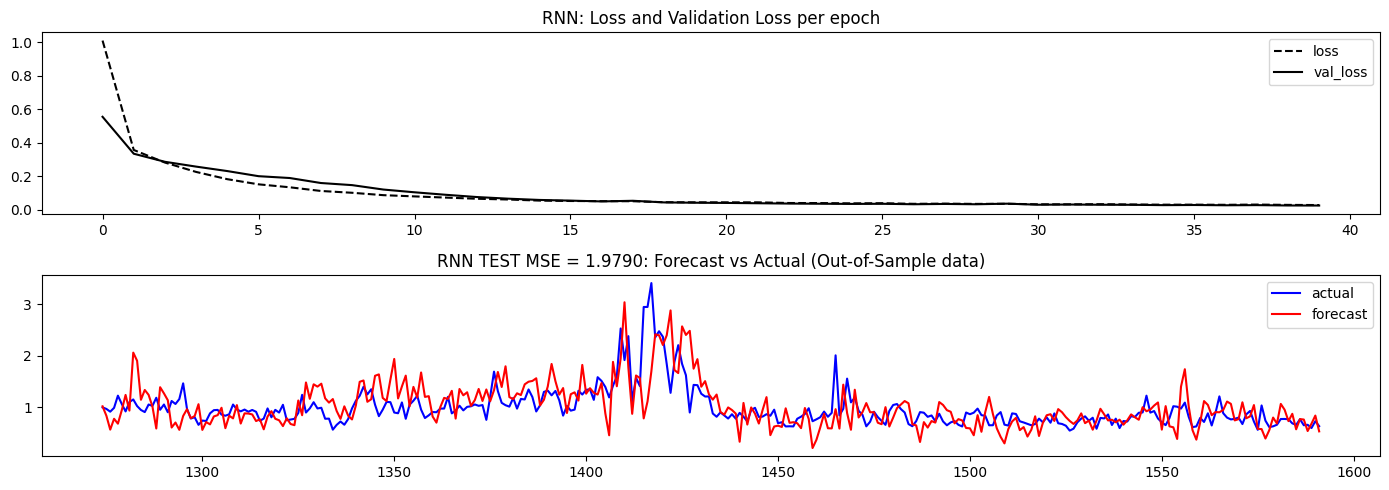

In [74]:

si_normal_rnn, history_normal_rnn = train_model_pt('RNN', **params_si)



## Inference simple RNN



## Inference sanity check first


In [75]:

model = si_normal_rnn


In [76]:


l_real, l_pred = inference_model_pt_2(model, model_type='RNN', **params_si)


0


In [77]:

l_real[:20]


[0.992852359661355,
 0.9630800253495575,
 0.9094733971215709,
 0.9837882927011662,
 1.2208307155584963,
 1.0601666844725495,
 0.9145106398894776,
 1.0963066886310293,
 1.147128203780218,
 1.0192058409237308,
 0.9427080614640855,
 0.9014426360386398,
 1.048595416956038,
 1.0216115619450303,
 1.1800714379419186,
 0.9466170077284312,
 1.0487394927348574,
 0.8986731944408893,
 1.1169999860836786,
 1.0589999779987553]

In [78]:

l_pred[:20]


[array([1.0134884], dtype=float32),
 array([0.83023536], dtype=float32),
 array([0.5610827], dtype=float32),
 array([0.77151304], dtype=float32),
 array([0.6763757], dtype=float32),
 array([0.93600184], dtype=float32),
 array([1.2348176], dtype=float32),
 array([0.93095976], dtype=float32),
 array([2.0563922], dtype=float32),
 array([1.8984475], dtype=float32),
 array([1.1406575], dtype=float32),
 array([1.3310056], dtype=float32),
 array([1.2358718], dtype=float32),
 array([1.008724], dtype=float32),
 array([0.58276474], dtype=float32),
 array([1.3845694], dtype=float32),
 array([1.2645715], dtype=float32),
 array([1.1321564], dtype=float32),
 array([0.6018629], dtype=float32),
 array([0.69877505], dtype=float32)]

In [79]:

## plt.rcParams["figure.figsize"] = [14, 5] 


318


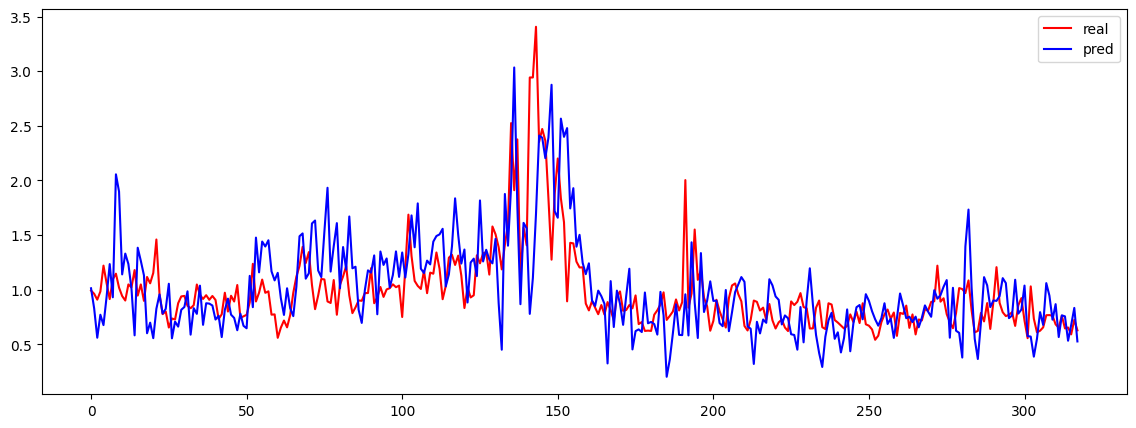

In [80]:


  
# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Now run actual INFERENCE to predict x vector and silicon together


In [81]:

model = si_normal_rnn


In [82]:

l_real, l_pred = inference_model_pt(model, model_type='RNN', **params_si)


0


In [83]:

l_real[:20]


[0.992852359661355,
 0.9630800253495575,
 0.9094733971215709,
 0.9837882927011662,
 1.2208307155584963,
 1.0601666844725495,
 0.9145106398894776,
 1.0963066886310293,
 1.147128203780218,
 1.0192058409237308,
 0.9427080614640855,
 0.9014426360386398,
 1.048595416956038,
 1.0216115619450303,
 1.1800714379419186,
 0.9466170077284312,
 1.0487394927348574,
 0.8986731944408893,
 1.1169999860836786,
 1.0589999779987553]

In [84]:

l_pred[:20]


[array([1.0134884], dtype=float32),
 array([1.1382037], dtype=float32),
 array([0.876858], dtype=float32),
 array([1.218553], dtype=float32),
 array([1.6224425], dtype=float32),
 array([2.7189164], dtype=float32),
 array([2.7465012], dtype=float32),
 array([1.1461784], dtype=float32),
 array([1.2099518], dtype=float32),
 array([1.77703], dtype=float32),
 array([0.9041676], dtype=float32),
 array([0.67371196], dtype=float32),
 array([0.85552764], dtype=float32),
 array([1.0944585], dtype=float32),
 array([0.73723495], dtype=float32),
 array([2.1368446], dtype=float32),
 array([3.0946298], dtype=float32),
 array([0.88798034], dtype=float32),
 array([1.2217015], dtype=float32),
 array([1.5630283], dtype=float32)]

318


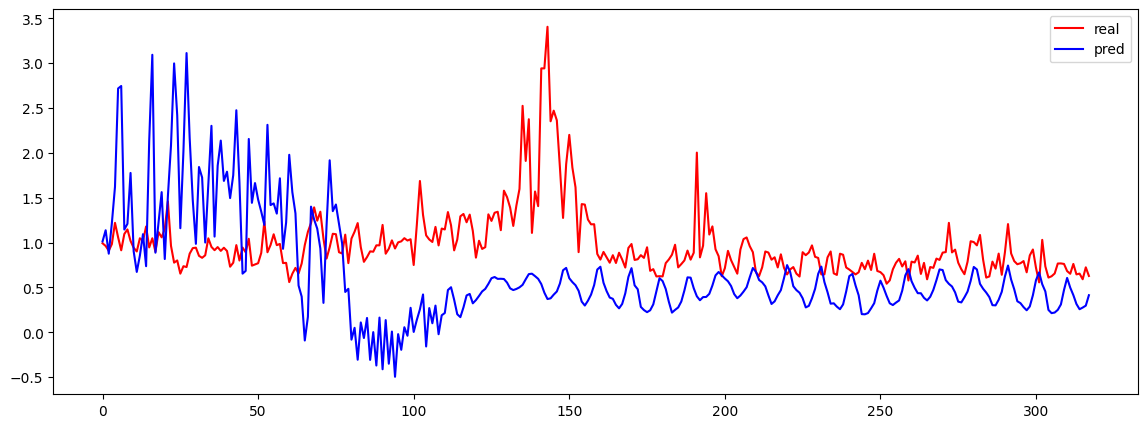

In [85]:

# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Break up test set into test bins 

* example
* input is 30 (about 7.5 hours)
* predicts rest of week


In [86]:

model = si_normal_rnn


In [87]:

x_test, y_test   = params_si['test_data']

## l_real, l_pred = bins_inference_model_pt(model, x_test, y_test)




In [88]:

x_test.shape


torch.Size([318, 78])

In [89]:

bin_size = int( x_test.shape[0] / window )
bin_size 


106

In [90]:

42486 / 1200


35.405

In [91]:

bin_size = 15


torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


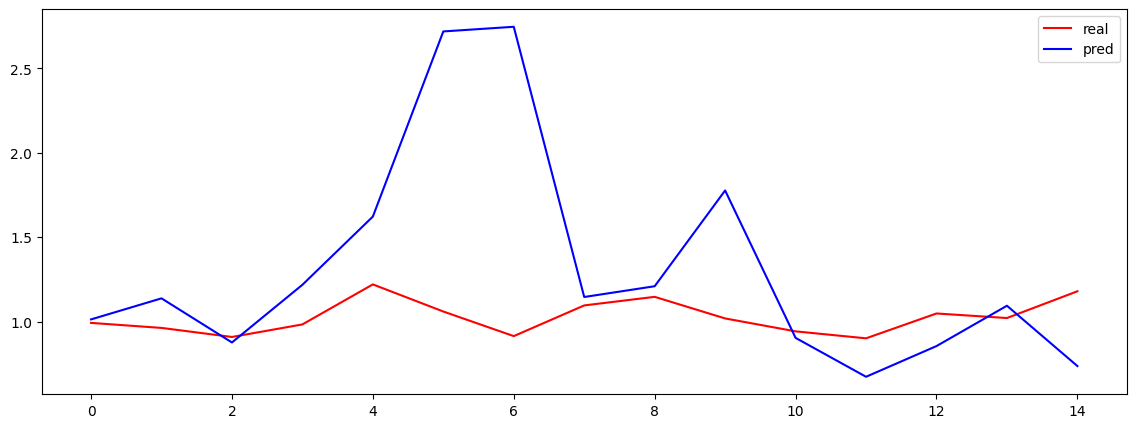

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


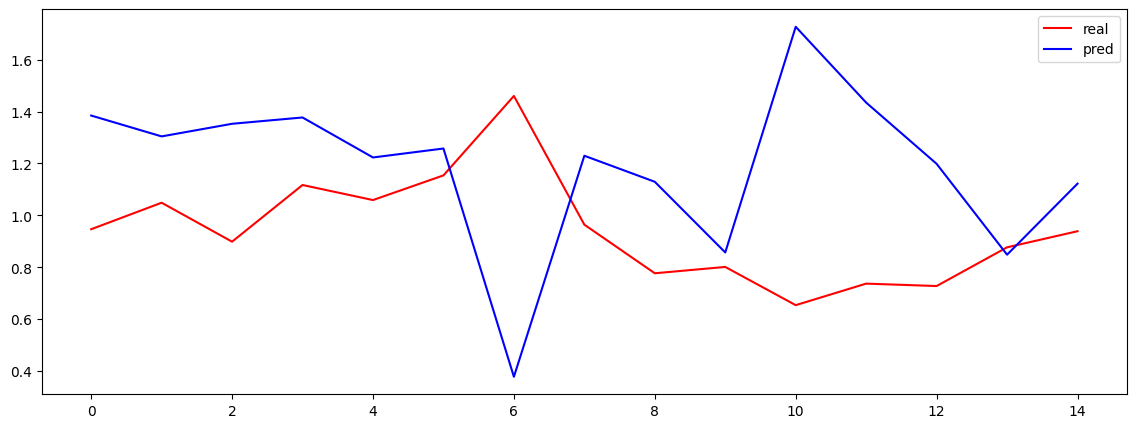

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


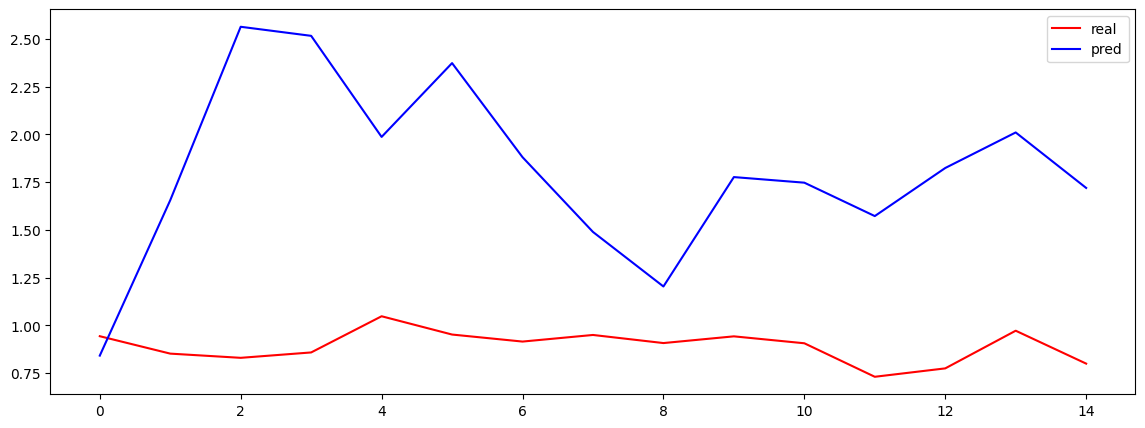

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


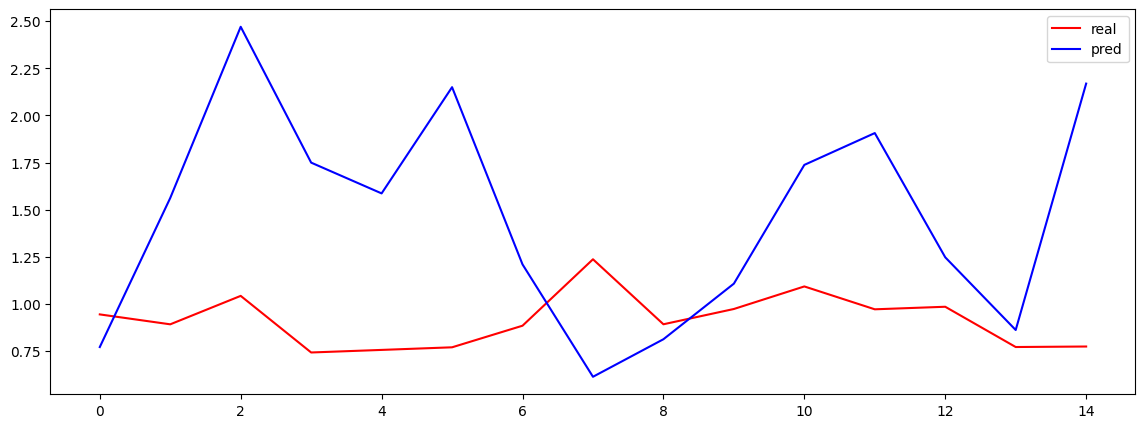

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


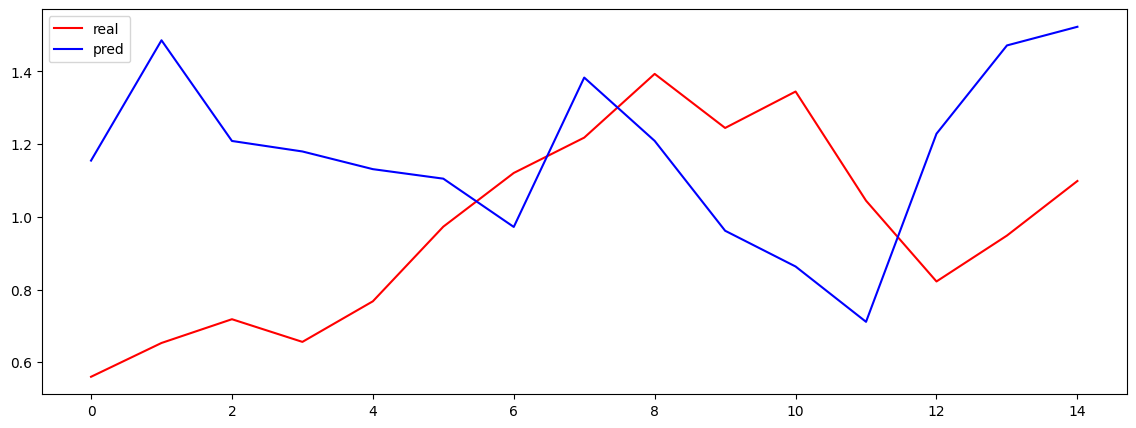

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


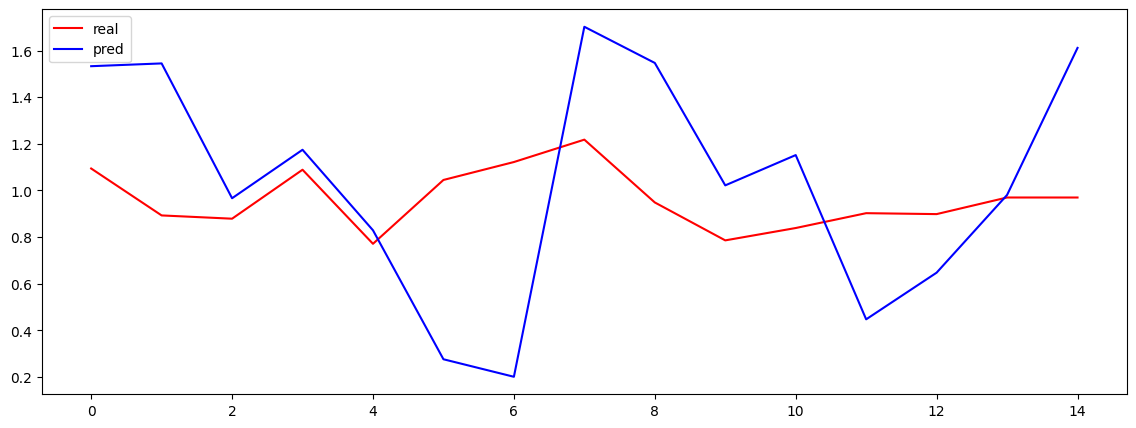

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


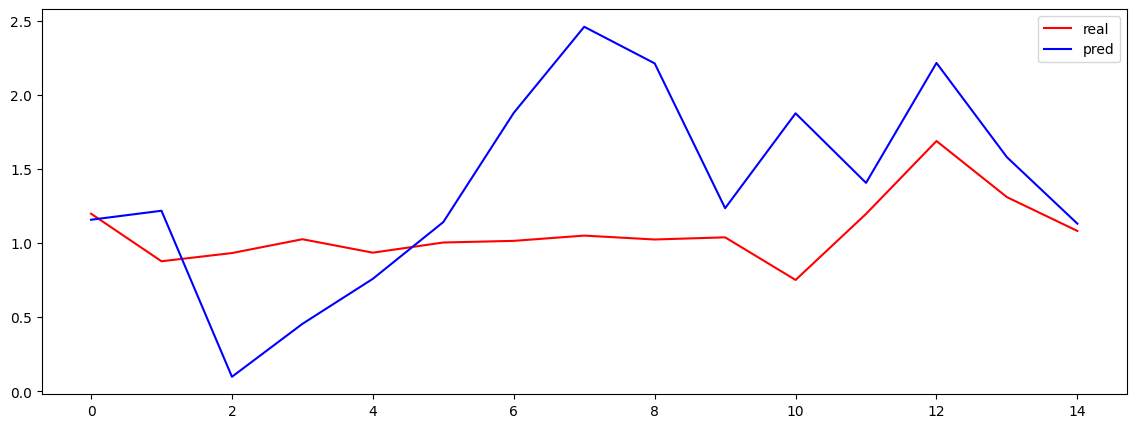

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


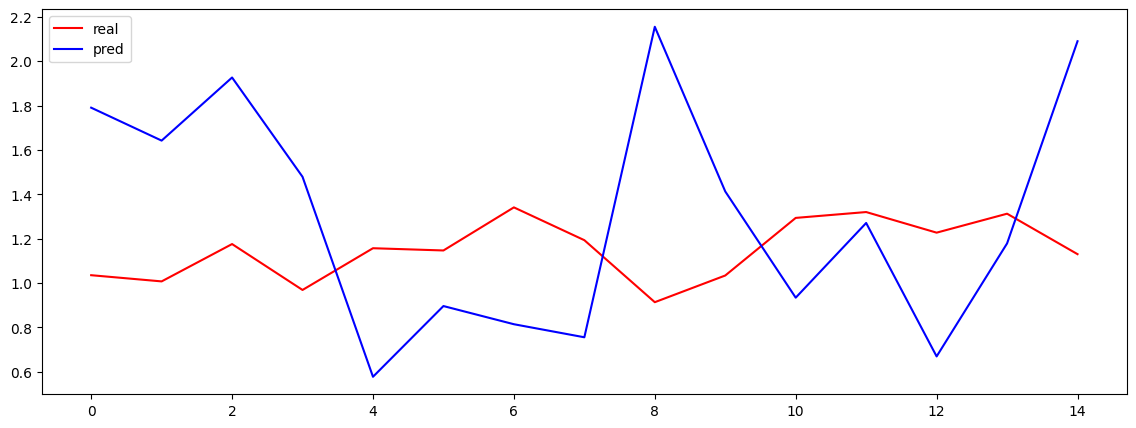

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


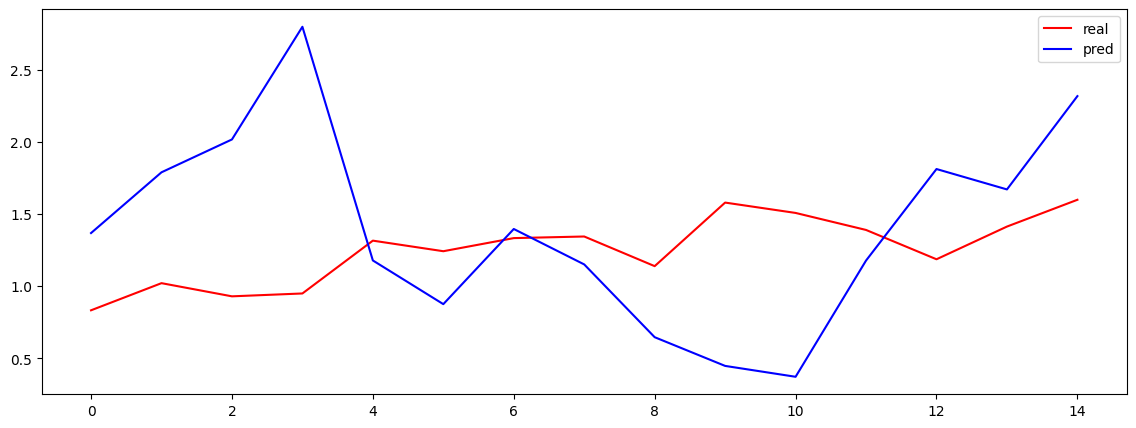

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


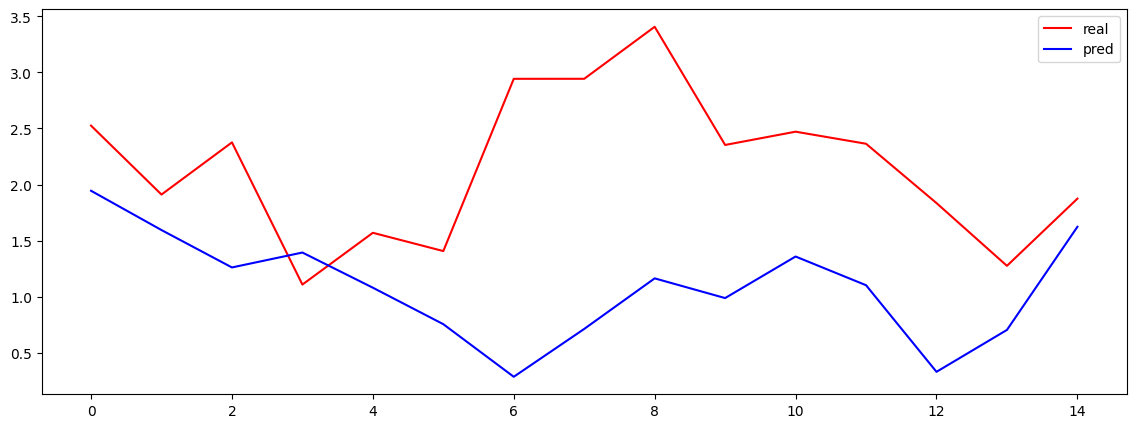

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


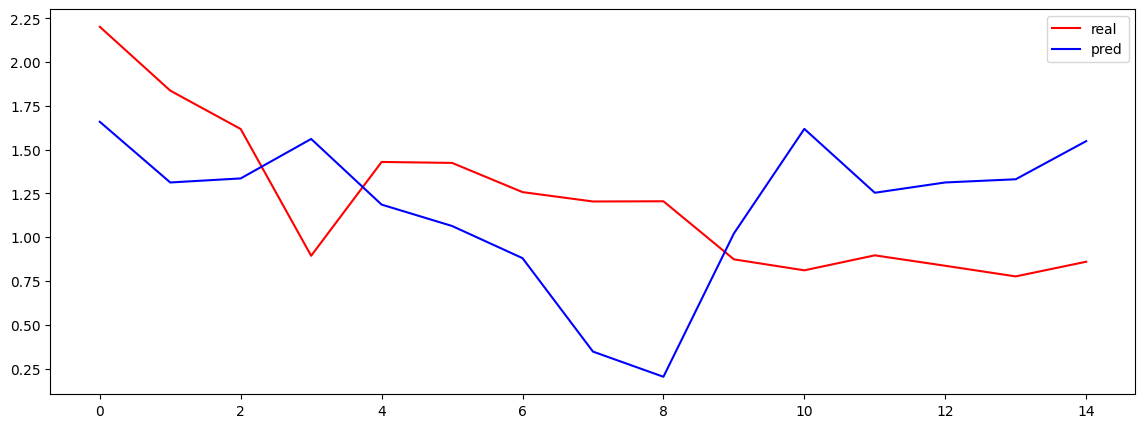

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


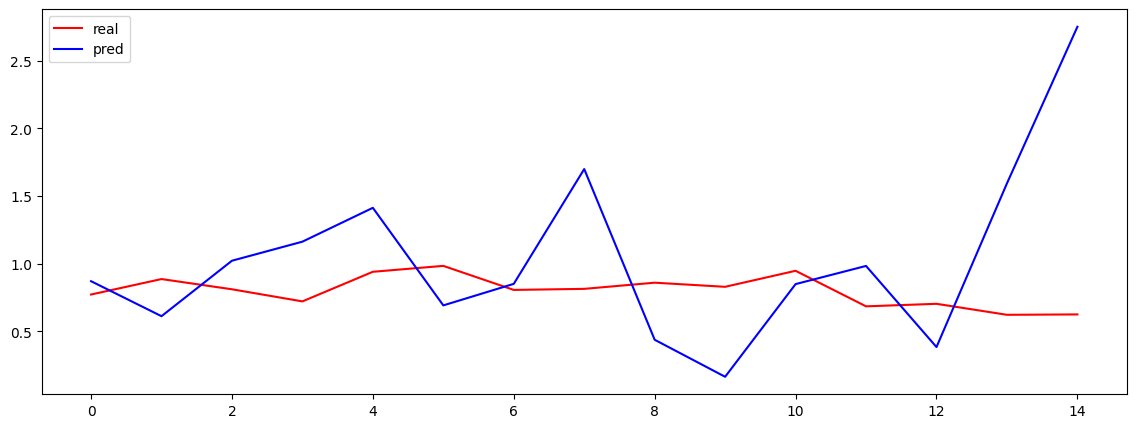

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


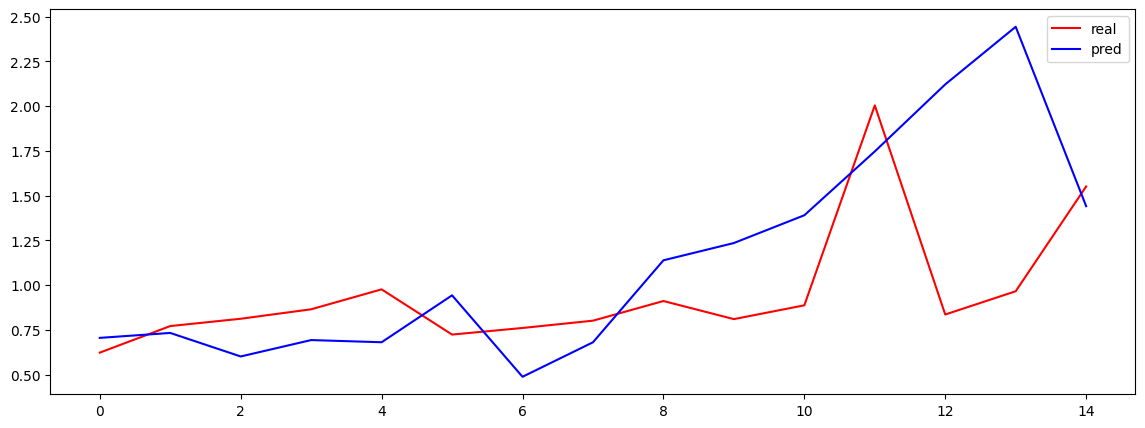

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


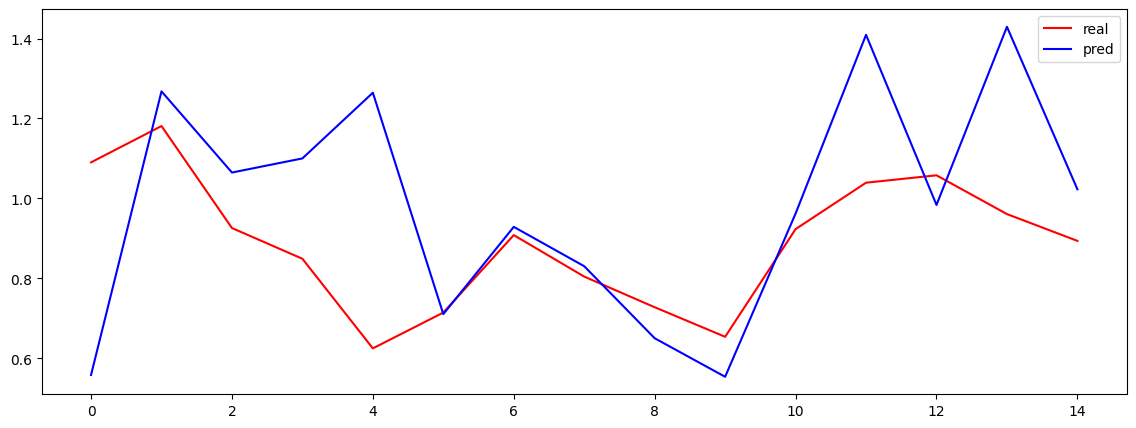

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


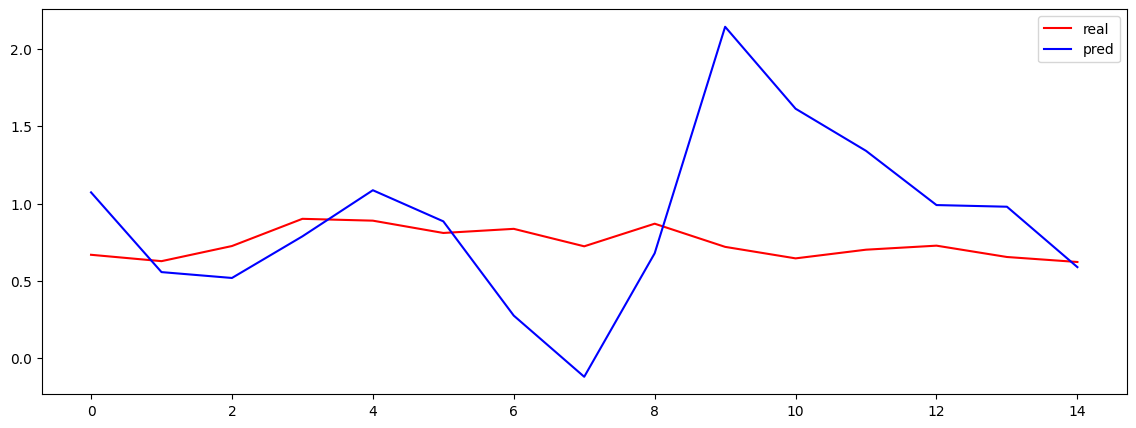

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


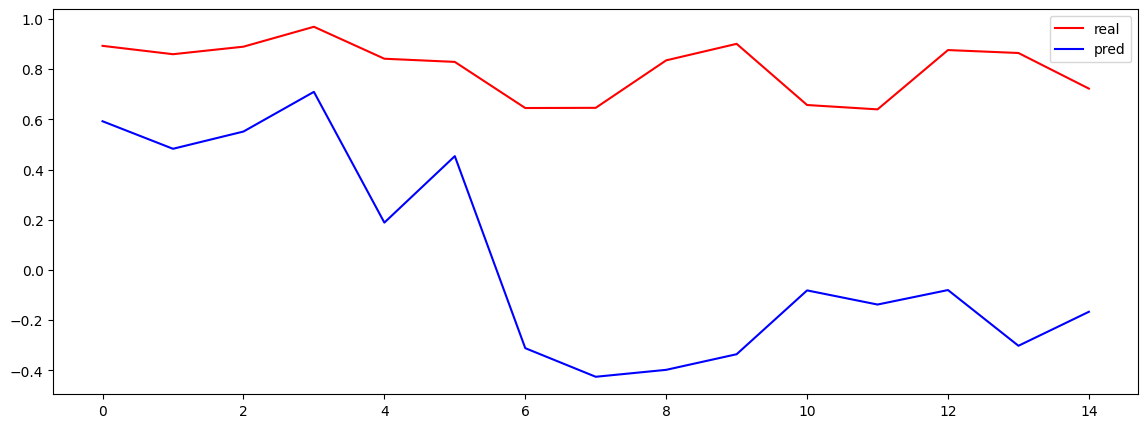

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


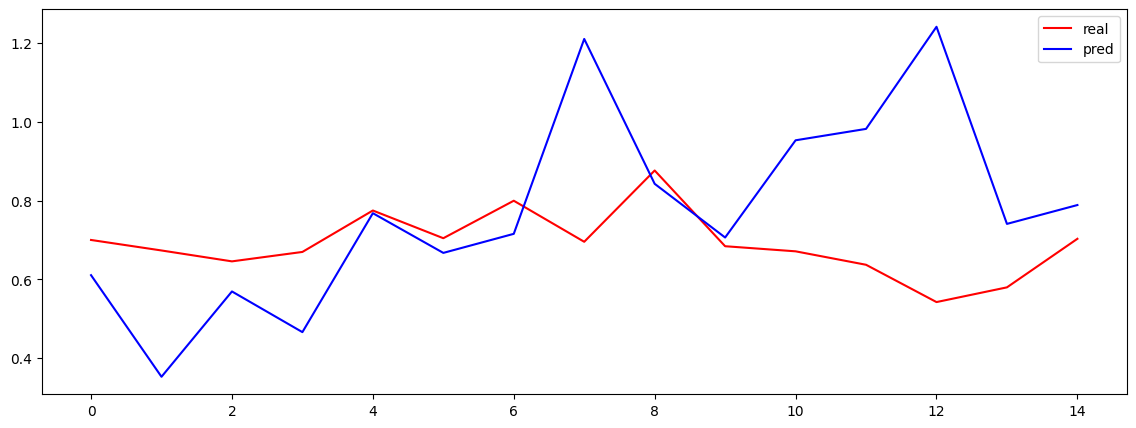

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


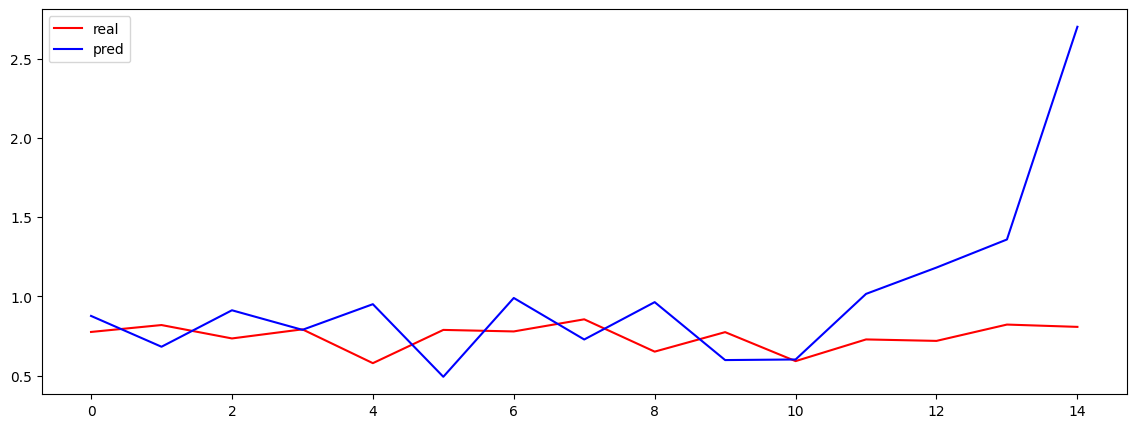

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


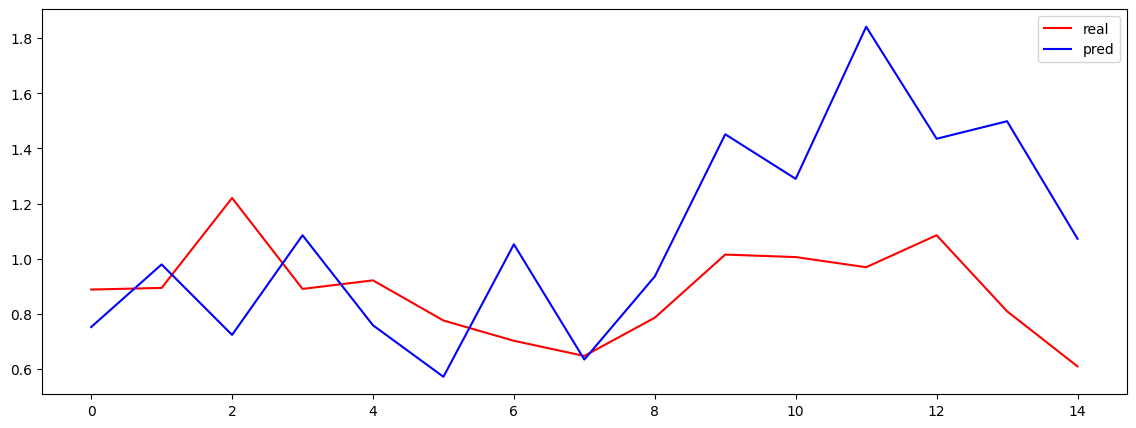

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


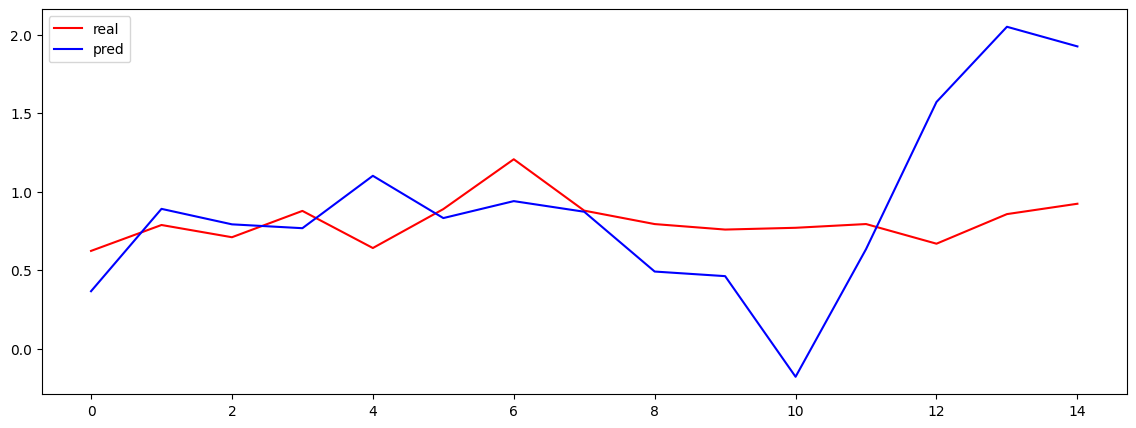

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


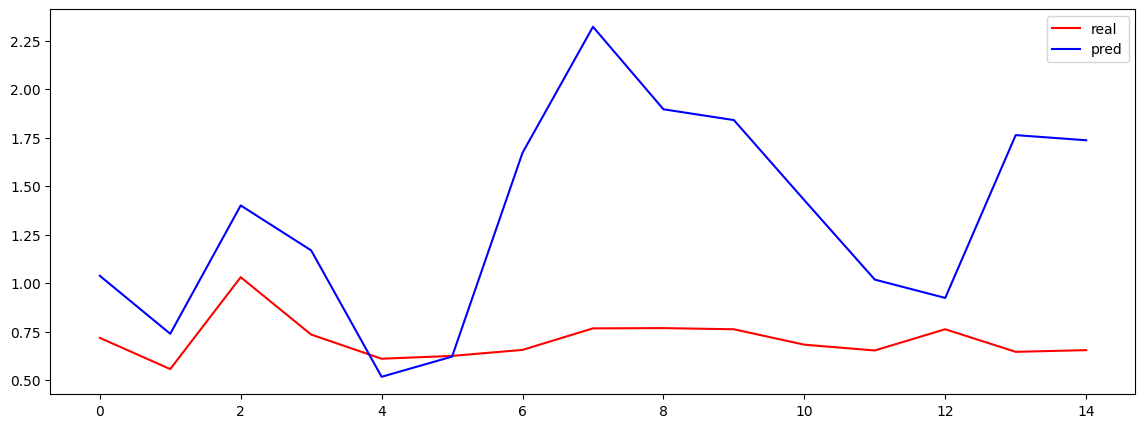

In [92]:

for i in range(0, y_test.shape[0]- bin_size, bin_size):
    batch_x_test = x_test[i:i+bin_size, :]
    print( batch_x_test.shape )

    batch_y_test = y_test[i:i+bin_size, :]
    print( batch_y_test.shape )
    print("---------------")
    bins_inference_model_pt(model, batch_x_test, batch_y_test)




## LSTM


In [93]:

class LSTM(nn.Module):
    def __init__(self, seq_length, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers   = n_layers
        self.hidden_dim = n_features
        self.output_size= output_size
        self.seq_length = seq_length
        self.input_size = input_size

        self.lstm    = nn.LSTM(input_size, n_features, n_layers, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc      = nn.Linear(n_features, output_size)

        self.fc1     = nn.Linear(n_features, 30)
        self.relu    = nn.ReLU()
        self.fc2     = nn.Linear(30, output_size)
        
    def forward(self, x, hn):
        x = x.view(-1, self.seq_length, self.input_size)
        x = x.permute(1, 0, 2)

        ## hn is a tuple here of (h0, c0)
        lstm_o, (hn, cn) = self.lstm(x, hn)
    
        lstm_o = self.dropout(lstm_o)

        
        output = self.fc( hn )
        ## output    = self.fc1( hn )
        ## output    = self.relu( output )
        ## output    = self.dropout(  output  )
        ## output    = self.fc2( output )
    
        ##                     batch_size, n_classes) 
        output  = output.view( -1,  self.output_size ) 
        
        return output, hn


    def init_hidden(self, batch_size_x_data):
        weight = next(self.parameters()).data
        hidden = ( weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, 1, self.hidden_dim).zero_()   )
        N_batches_rc = batch_size_x_data    ## or is this the size of the x set ??
        hidden2 = ( torch.zeros( self.n_layers,   N_batches_rc,    self.hidden_dim ),
                    torch.zeros( self.n_layers,   N_batches_rc,    self.hidden_dim )    )
        return hidden2


0/1000 - Loss:  0.9987712502479553, val_loss: 0.5952943563461304
25/1000 - Loss:  0.33690565824508667, val_loss: 0.3263451159000397
50/1000 - Loss:  0.24696968495845795, val_loss: 0.2676337957382202
75/1000 - Loss:  0.1765293926000595, val_loss: 0.2190197855234146
100/1000 - Loss:  0.13198179006576538, val_loss: 0.1801128387451172
125/1000 - Loss:  0.09784962981939316, val_loss: 0.13764657080173492
150/1000 - Loss:  0.07491903752088547, val_loss: 0.10564524680376053
175/1000 - Loss:  0.06348680704832077, val_loss: 0.09529537707567215
200/1000 - Loss:  0.045524485409259796, val_loss: 0.05675119161605835
225/1000 - Loss:  0.03685171157121658, val_loss: 0.044326893985271454
250/1000 - Loss:  0.030274776741862297, val_loss: 0.03145977109670639
275/1000 - Loss:  0.02632252126932144, val_loss: 0.025960661470890045
300/1000 - Loss:  0.022425474599003792, val_loss: 0.022470863536000252
325/1000 - Loss:  0.019581420347094536, val_loss: 0.018066857010126114
350/1000 - Loss:  0.02053542621433735,

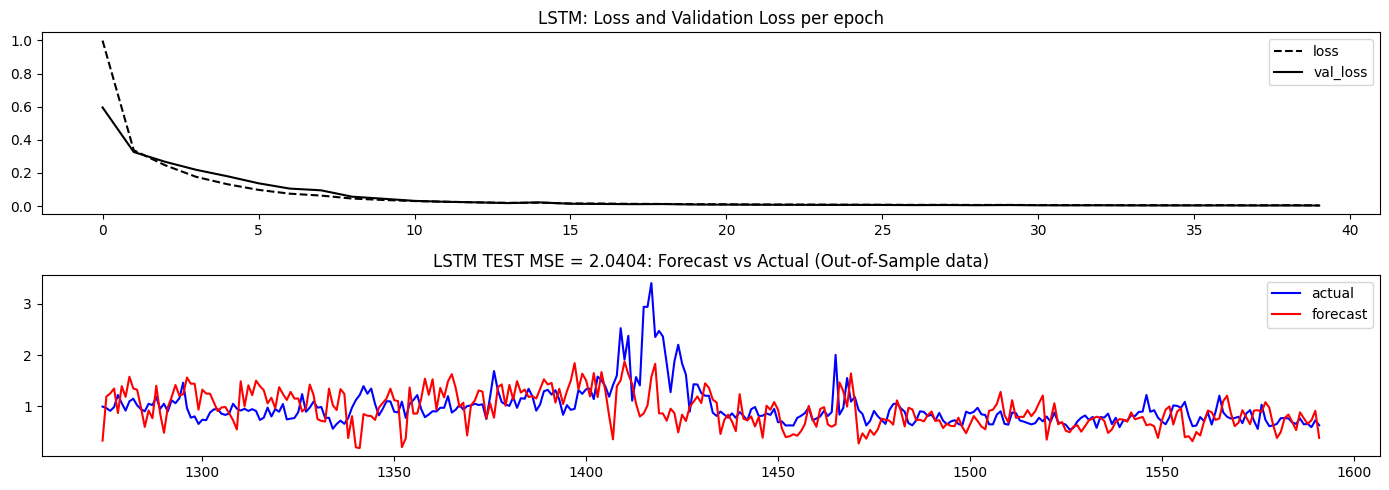

In [94]:

si_lstm, history_a_lstm = train_model_pt('LSTM', **params_si)



## LSTM Inference



## Inference sanity check first


In [95]:

model = si_lstm


In [96]:

l_real, l_pred = inference_model_pt_2(model, model_type='LSTM', **params_si)


0


In [97]:

l_real[:20]


[0.992852359661355,
 0.9630800253495575,
 0.9094733971215709,
 0.9837882927011662,
 1.2208307155584963,
 1.0601666844725495,
 0.9145106398894776,
 1.0963066886310293,
 1.147128203780218,
 1.0192058409237308,
 0.9427080614640855,
 0.9014426360386398,
 1.048595416956038,
 1.0216115619450303,
 1.1800714379419186,
 0.9466170077284312,
 1.0487394927348574,
 0.8986731944408893,
 1.1169999860836786,
 1.0589999779987553]

In [98]:

l_pred[:20]


[array([0.32757288], dtype=float32),
 array([1.1904128], dtype=float32),
 array([1.2491596], dtype=float32),
 array([1.3457936], dtype=float32),
 array([0.8667304], dtype=float32),
 array([1.3920527], dtype=float32),
 array([1.1828829], dtype=float32),
 array([1.5764995], dtype=float32),
 array([1.347625], dtype=float32),
 array([1.3232015], dtype=float32),
 array([0.9801785], dtype=float32),
 array([0.59550726], dtype=float32),
 array([0.9172494], dtype=float32),
 array([0.76519054], dtype=float32),
 array([1.4004683], dtype=float32),
 array([0.8620082], dtype=float32),
 array([0.48123878], dtype=float32),
 array([0.9763653], dtype=float32),
 array([1.1799093], dtype=float32),
 array([1.4147067], dtype=float32)]

318


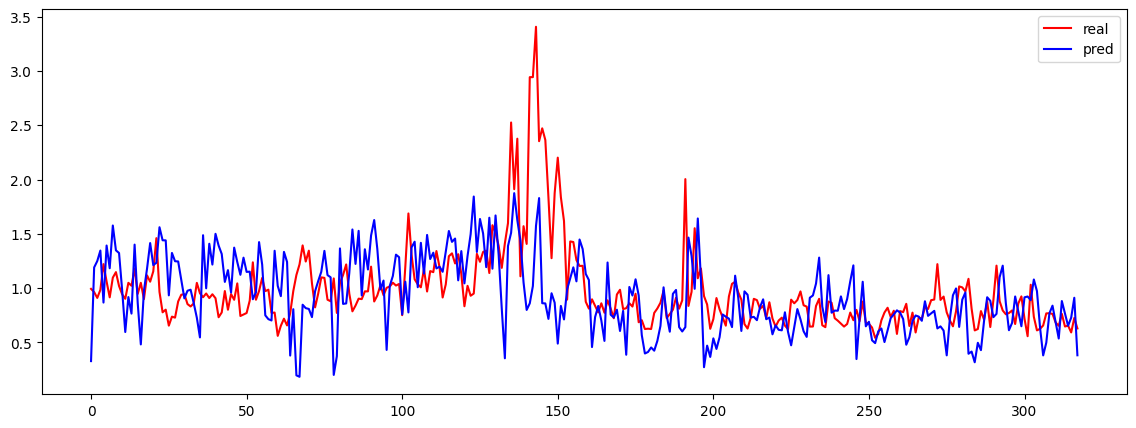

In [99]:

# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Now run actual INFERENCE to predict x vector and silicon together


In [100]:

model = si_lstm


In [101]:

l_real, l_pred = inference_model_pt(model, model_type='LSTM', **params_si)


0


In [102]:

l_real[:50]


[0.992852359661355,
 0.9630800253495575,
 0.9094733971215709,
 0.9837882927011662,
 1.2208307155584963,
 1.0601666844725495,
 0.9145106398894776,
 1.0963066886310293,
 1.147128203780218,
 1.0192058409237308,
 0.9427080614640855,
 0.9014426360386398,
 1.048595416956038,
 1.0216115619450303,
 1.1800714379419186,
 0.9466170077284312,
 1.0487394927348574,
 0.8986731944408893,
 1.1169999860836786,
 1.0589999779987553,
 1.1539999868740987,
 1.4599630730913908,
 0.9642500120296381,
 0.7770000103114325,
 0.8014138469159996,
 0.6541764727185755,
 0.7371185277176617,
 0.7278170785187535,
 0.876922477425918,
 0.9390000098928563,
 0.9438860945703975,
 0.8527525961375322,
 0.8307554821212947,
 0.8589317406661551,
 1.0482456464911194,
 0.952581077109734,
 0.9158200184502119,
 0.9503839172611084,
 0.9080000129958494,
 0.9431447088468523,
 0.9069230771032195,
 0.7316078487025645,
 0.7755384821050542,
 0.9726199966272073,
 0.8004740699257573,
 0.9449705848055457,
 0.8923706838657042,
 1.043220573098562

In [103]:

l_pred[:500]


[array([0.32757288], dtype=float32),
 array([0.11754853], dtype=float32),
 array([0.8956235], dtype=float32),
 array([1.377775], dtype=float32),
 array([0.9571489], dtype=float32),
 array([1.0777727], dtype=float32),
 array([0.977927], dtype=float32),
 array([1.1867203], dtype=float32),
 array([1.388809], dtype=float32),
 array([1.1926804], dtype=float32),
 array([1.4832802], dtype=float32),
 array([1.6283325], dtype=float32),
 array([1.4294336], dtype=float32),
 array([1.990935], dtype=float32),
 array([1.3304055], dtype=float32),
 array([1.089837], dtype=float32),
 array([1.36234], dtype=float32),
 array([0.7465582], dtype=float32),
 array([1.0445181], dtype=float32),
 array([0.85635495], dtype=float32),
 array([0.7252481], dtype=float32),
 array([0.7995016], dtype=float32),
 array([0.6204096], dtype=float32),
 array([1.5622516], dtype=float32),
 array([1.0022019], dtype=float32),
 array([0.67589444], dtype=float32),
 array([1.0275836], dtype=float32),
 array([1.0657381], dtype=float

318


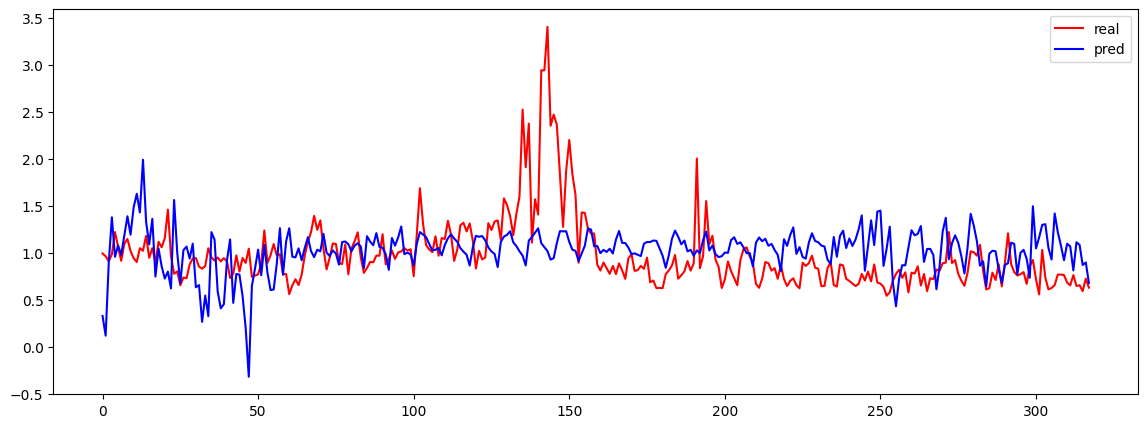

In [104]:

# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Break up test set into test bins 

* example
* input is 30 (about 7.5 hours)
* predicts rest of week


In [105]:

model = si_lstm


In [106]:


x_test, y_test   = params_si['test_data']

## l_real, l_pred = bins_inference_model_pt(model, x_test, y_test)



In [107]:

x_test.shape


torch.Size([318, 78])

In [108]:

bin_size = int( x_test.shape[0] / window )
bin_size 


106

In [109]:

bin_size = 15


torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


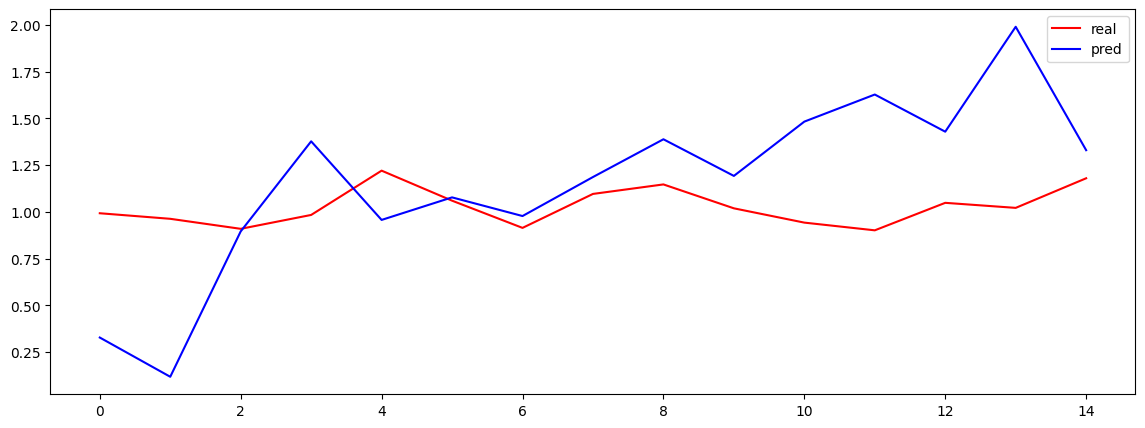

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


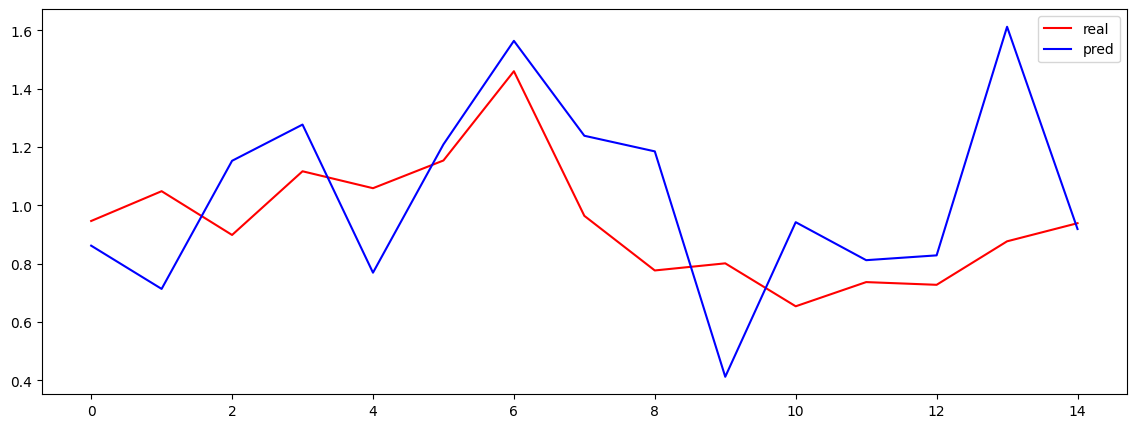

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


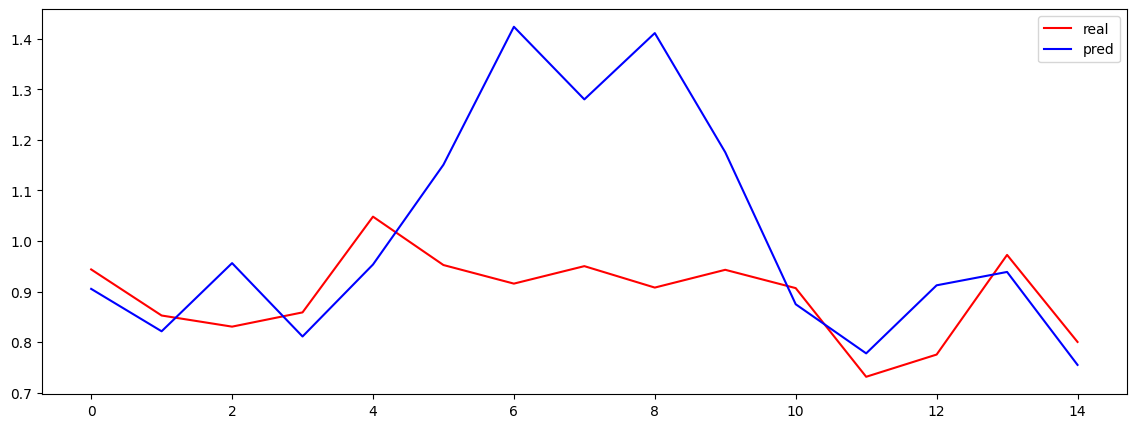

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


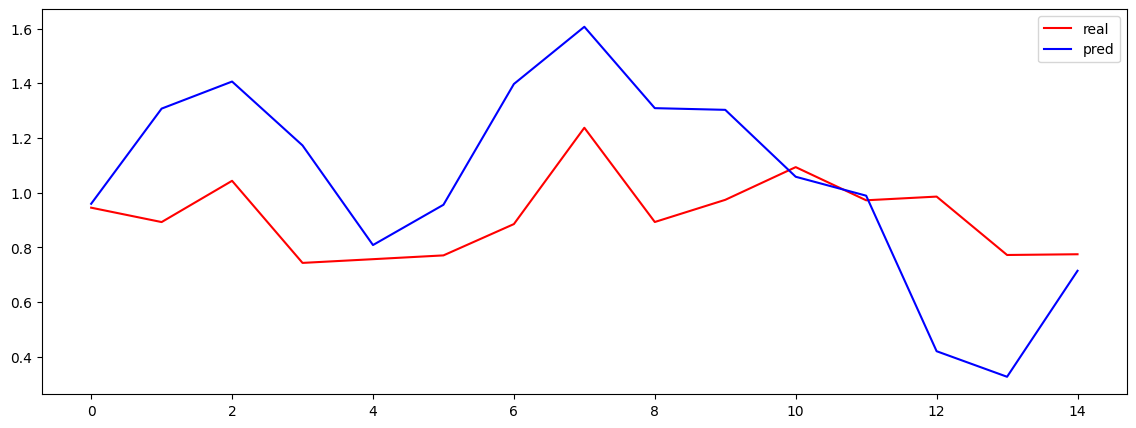

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


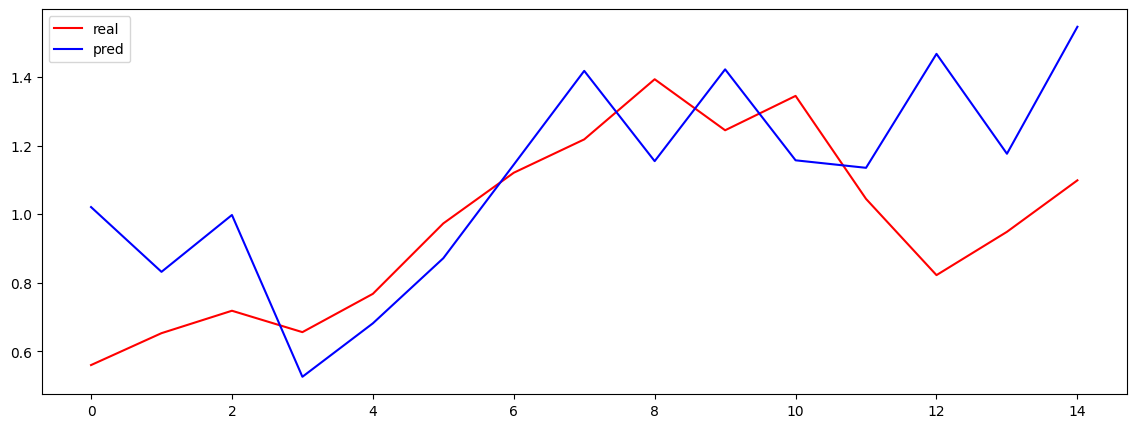

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


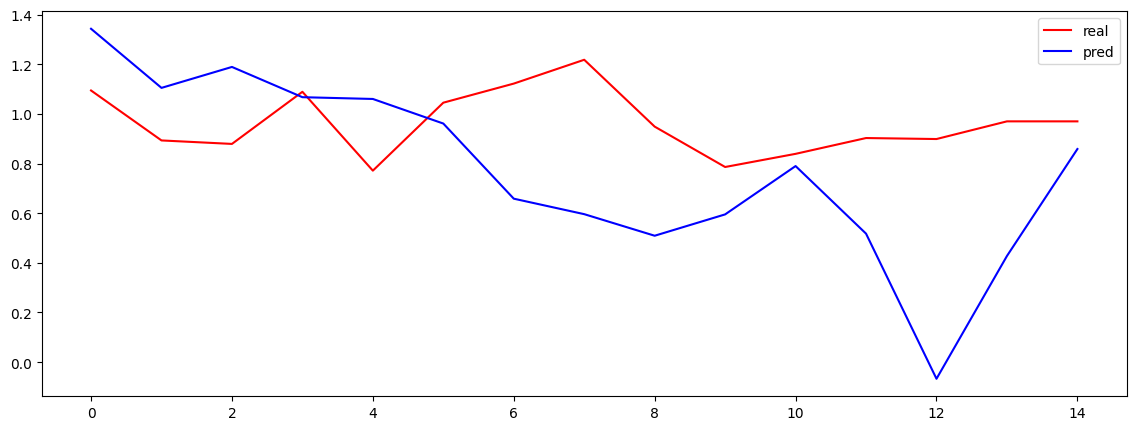

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


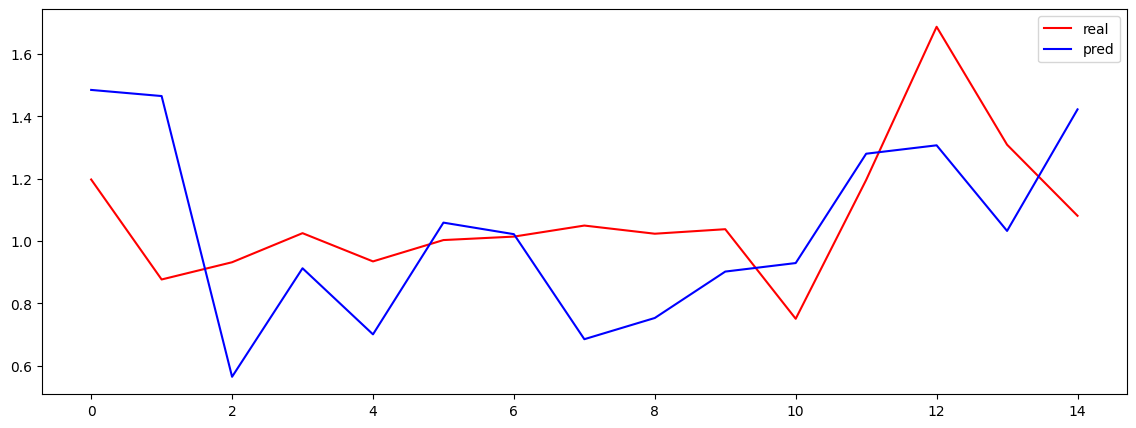

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


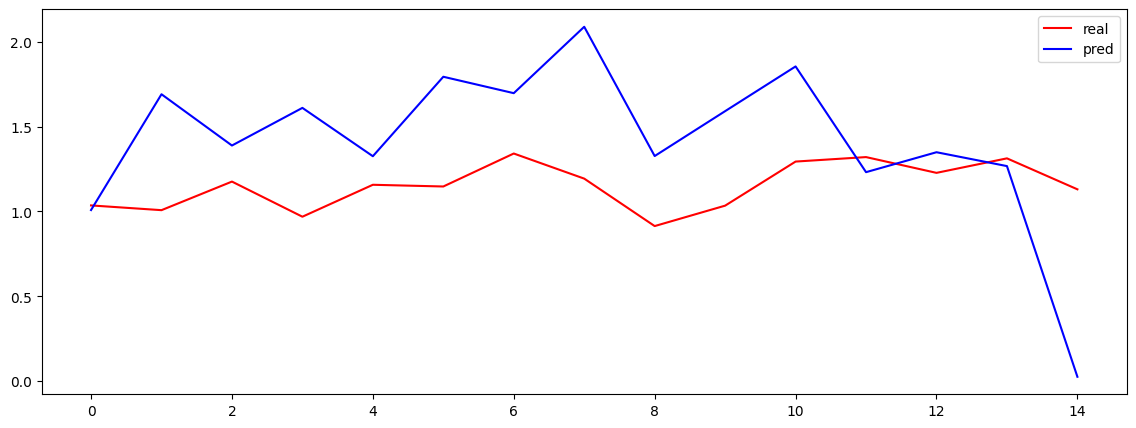

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


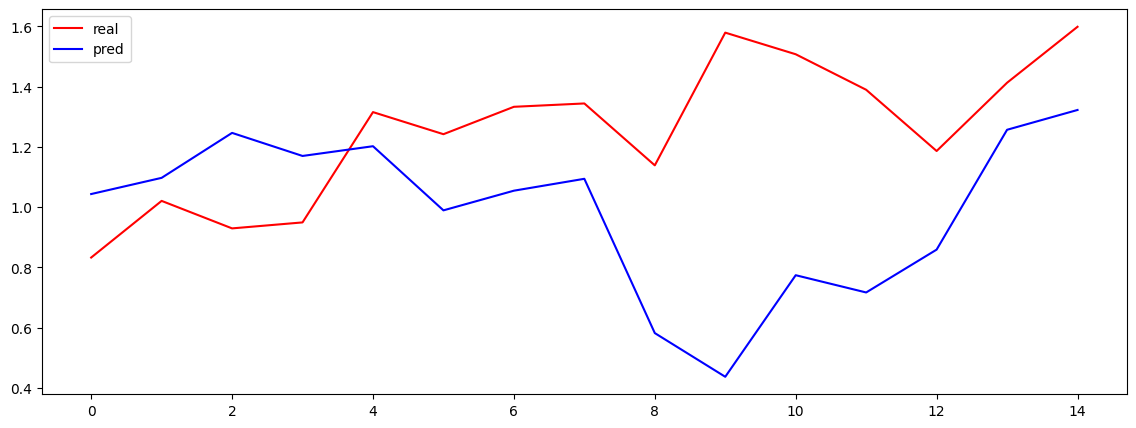

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


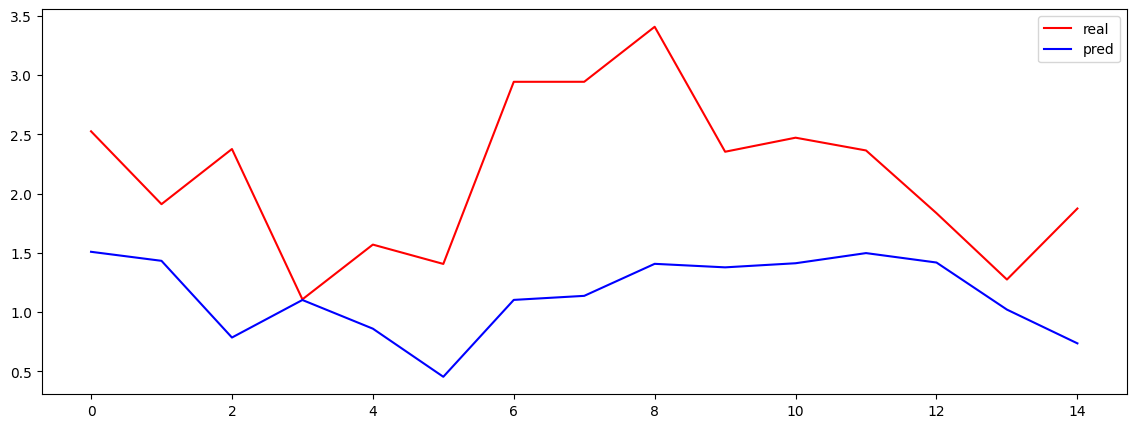

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


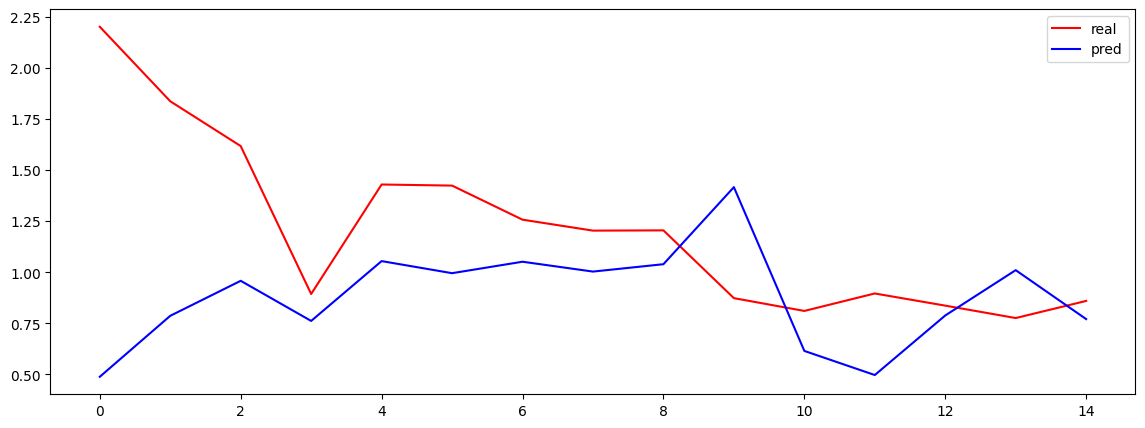

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


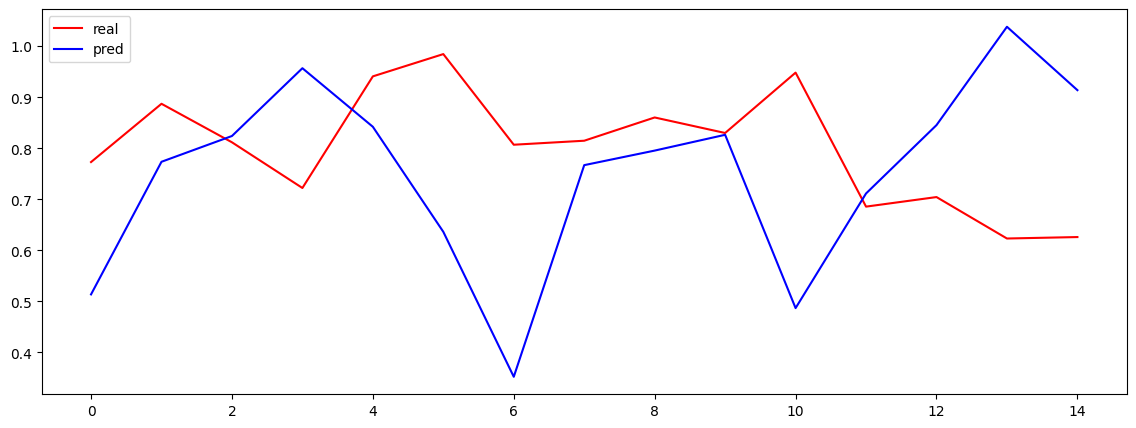

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


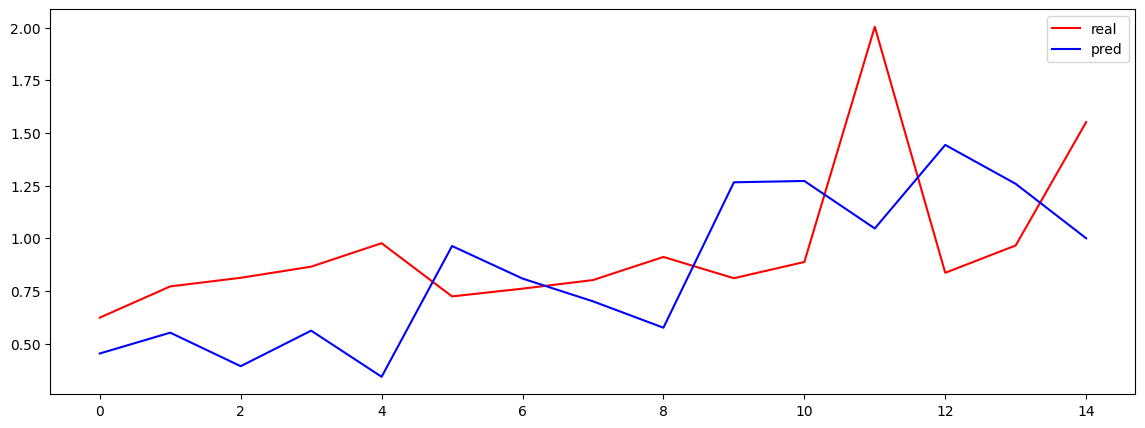

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


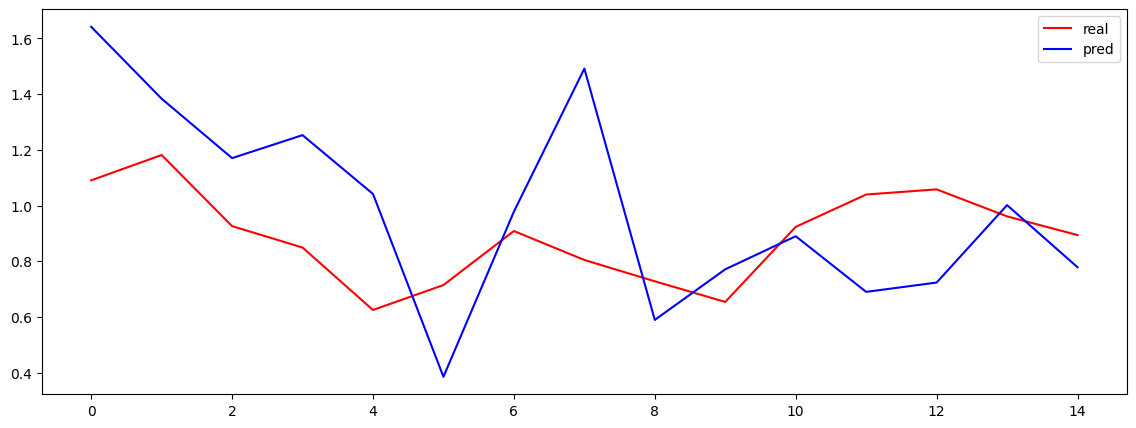

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


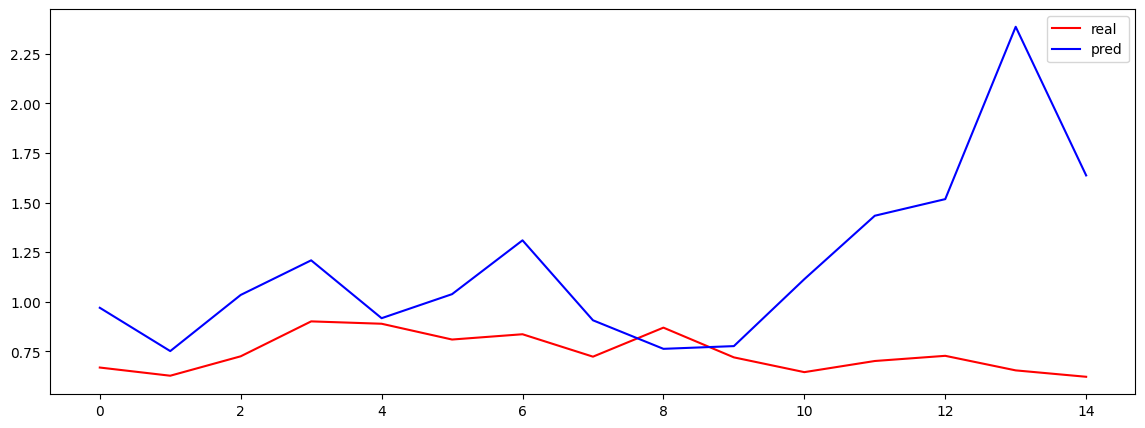

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


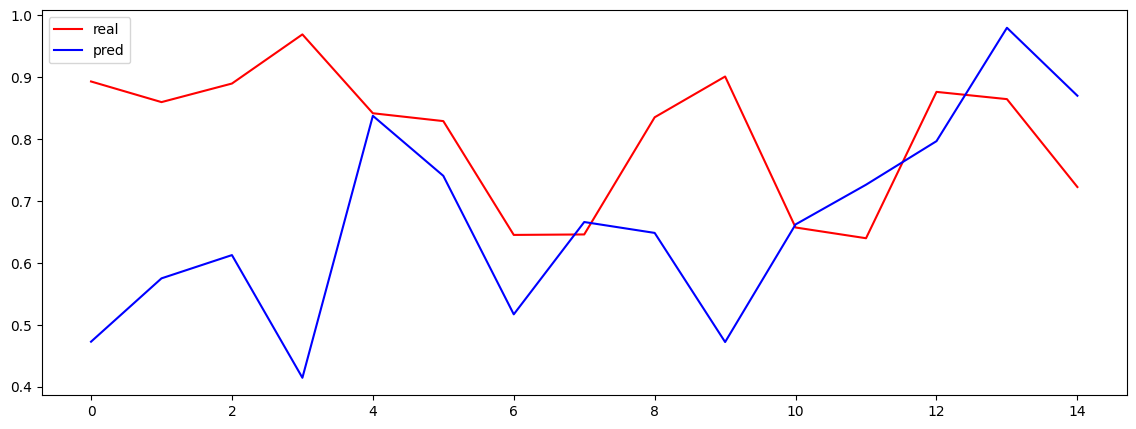

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


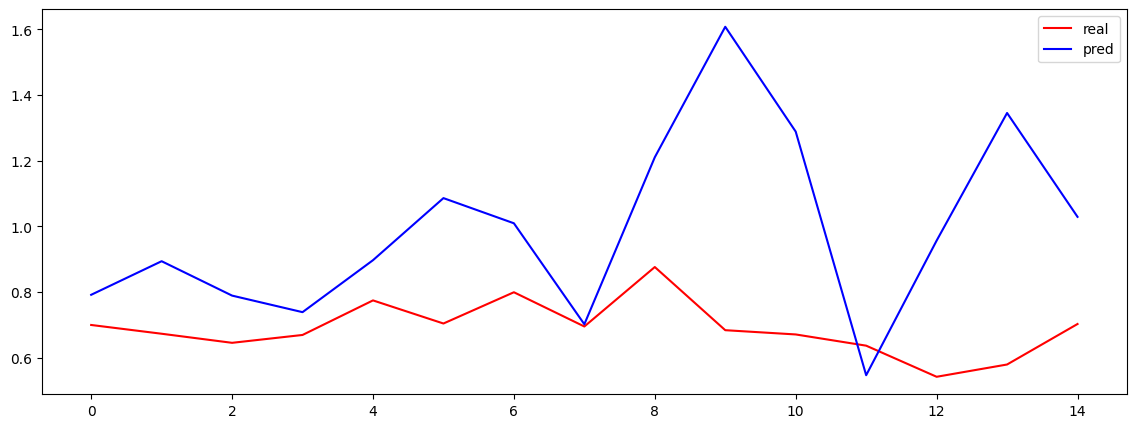

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


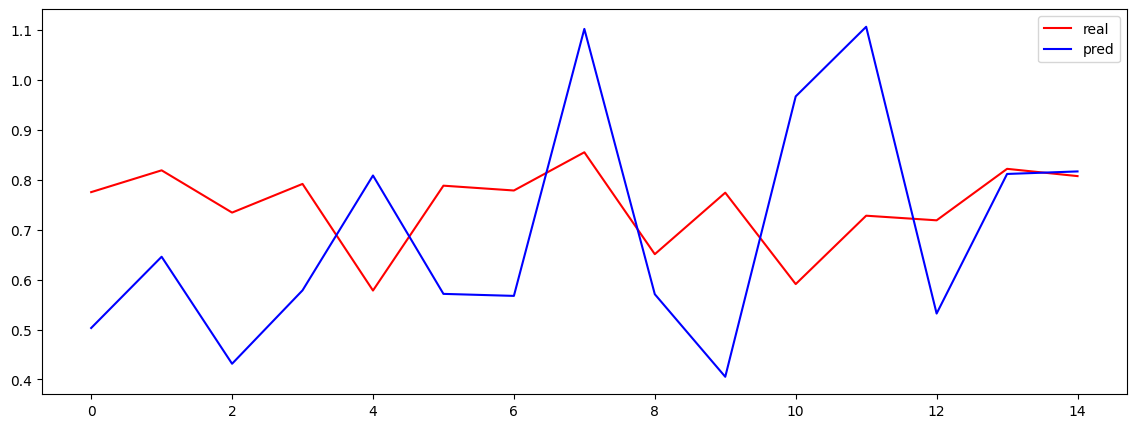

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


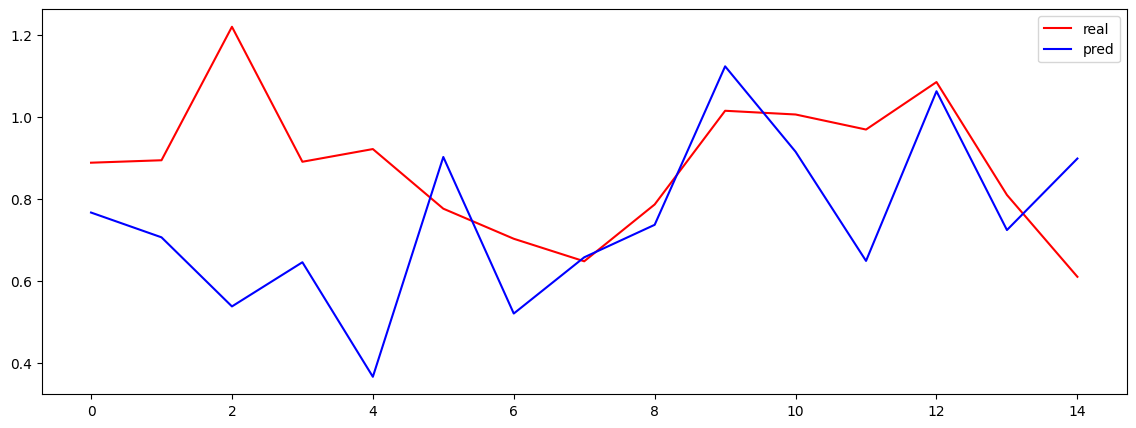

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


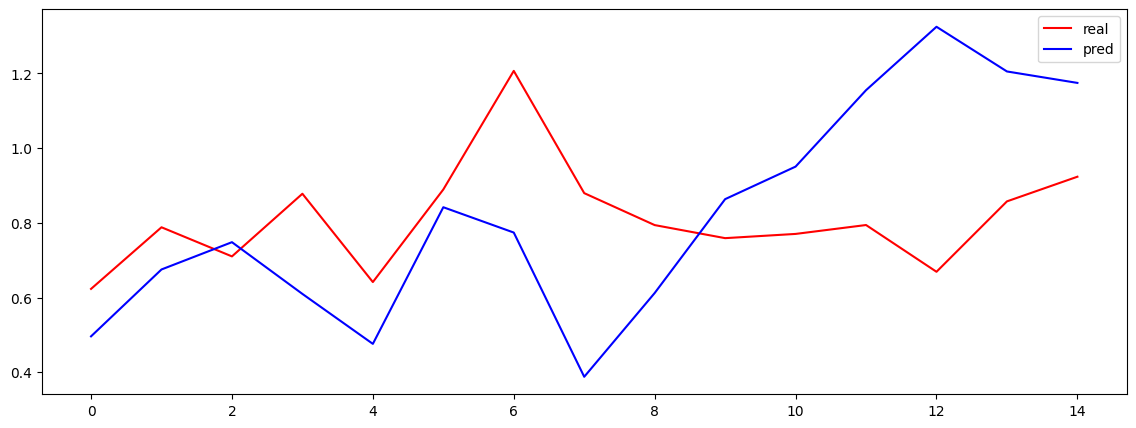

torch.Size([15, 78])
torch.Size([15, 26])
---------------
0
15


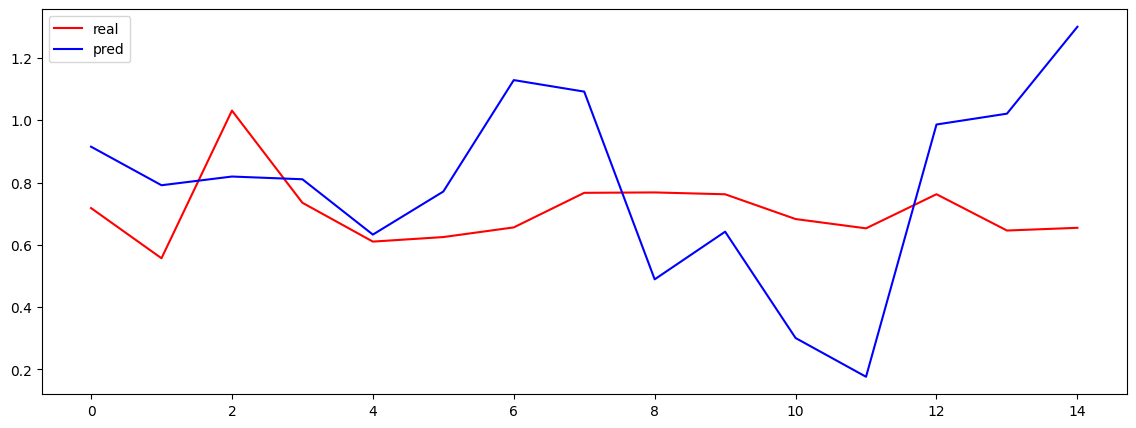

In [110]:



for i in range(0, y_test.shape[0]- bin_size, bin_size):
    batch_x_test = x_test[i:i+bin_size, :]
    print( batch_x_test.shape )

    batch_y_test = y_test[i:i+bin_size, :]
    print( batch_y_test.shape )
    print("---------------")
    bins_inference_model_pt(model, batch_x_test, batch_y_test)



## View all predicted Xs


In [111]:


            
            
def View_all_predicted_Xs(x_index, model, model_type='RNN', **kwargs):
 
    x_test, y_test   = kwargs['test_data']
 
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0    = model.init_hidden( x_test.shape[0] )
        y_hat = model(x_test, h0)
        
    y_hat, _ = y_hat
 
    ## Plotting
    fig, ax = plt.subplots(2, 1) 
    
    ax[0].set_title(f"{model_type} TEST MSE = {0:.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    print("ricardo check this")
    print(y_test.shape)
    print(y_hat.shape )
    actual = scale.inverse_y(y_test.detach().numpy() ) ## .ravel() )
    pred   = scale.inverse_y( y_hat.detach().numpy() ) ## .ravel() )
    idx = kwargs['idx']
    ##pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65, color='blue')
    ##pd.Series(pred,   index=idx).plot(style='k',   label='forecast' , color='red')
    print(actual.shape)
    print(pred.shape)
    actual = actual[:, x_index]
    pred   =   pred[:, x_index]
    
    pd.Series(pred,   index=idx).plot( label='forecast' , color='red' )
    pd.Series(actual, index=idx).plot( label='actual',    color='blue')
    
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return 0, 0
    
           

            



ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


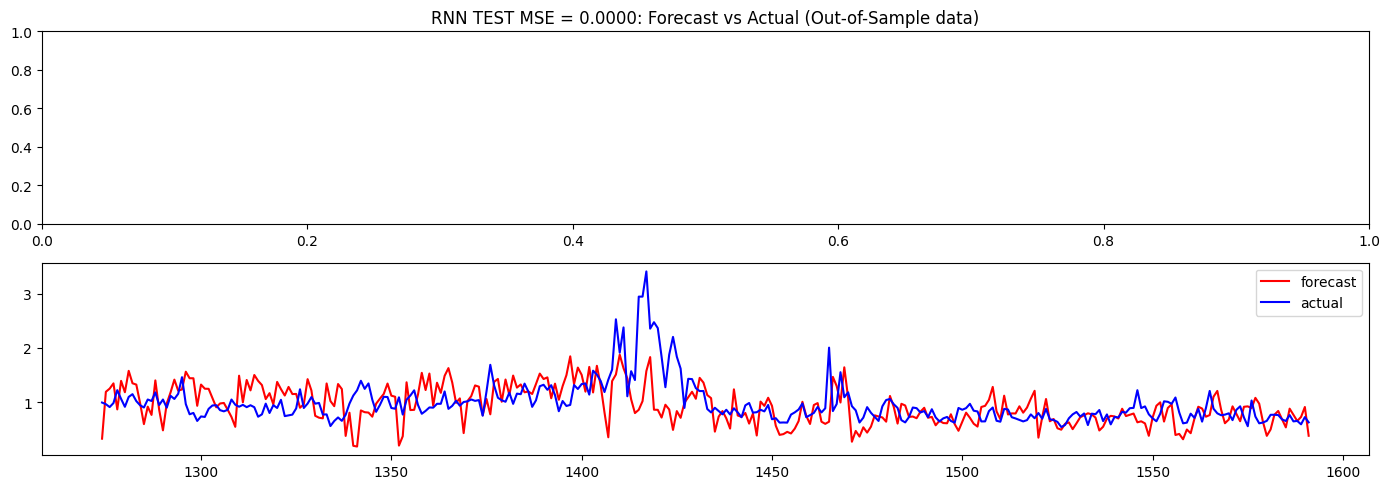

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


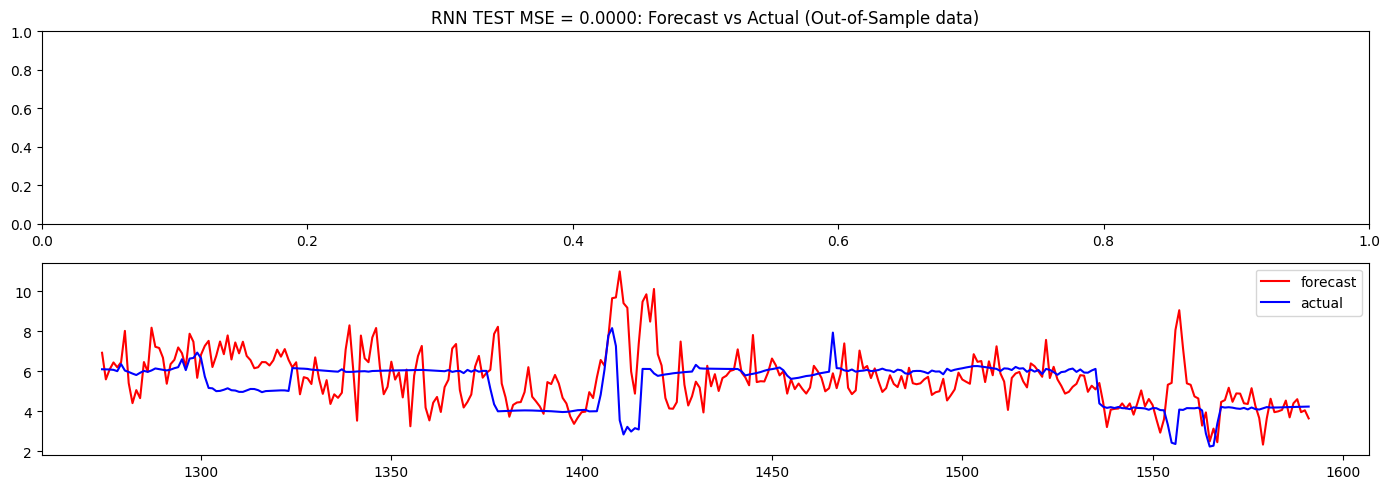

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


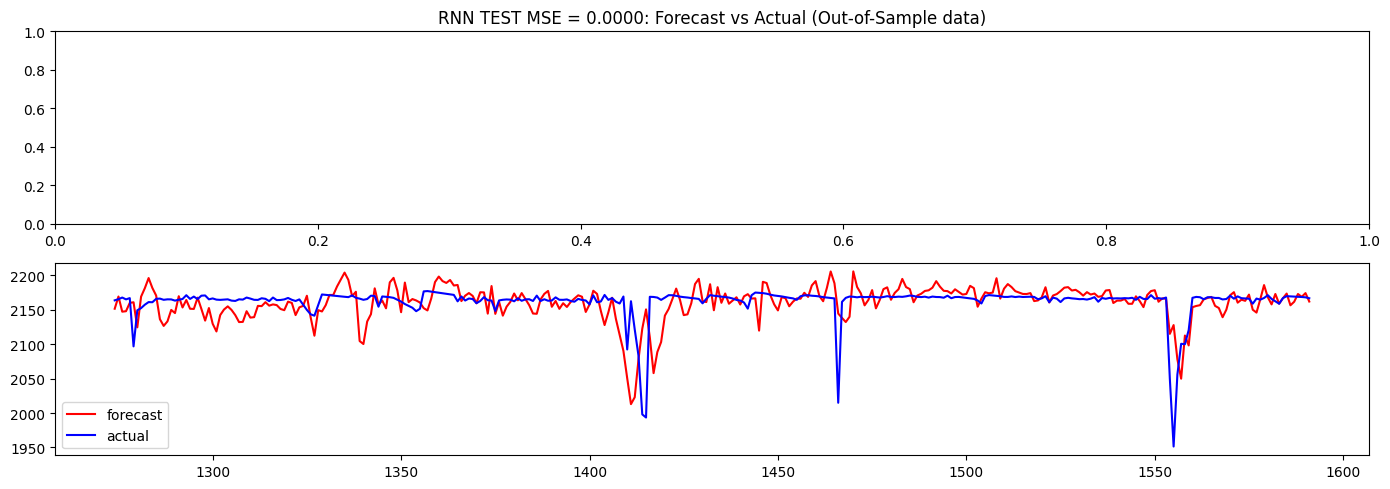

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


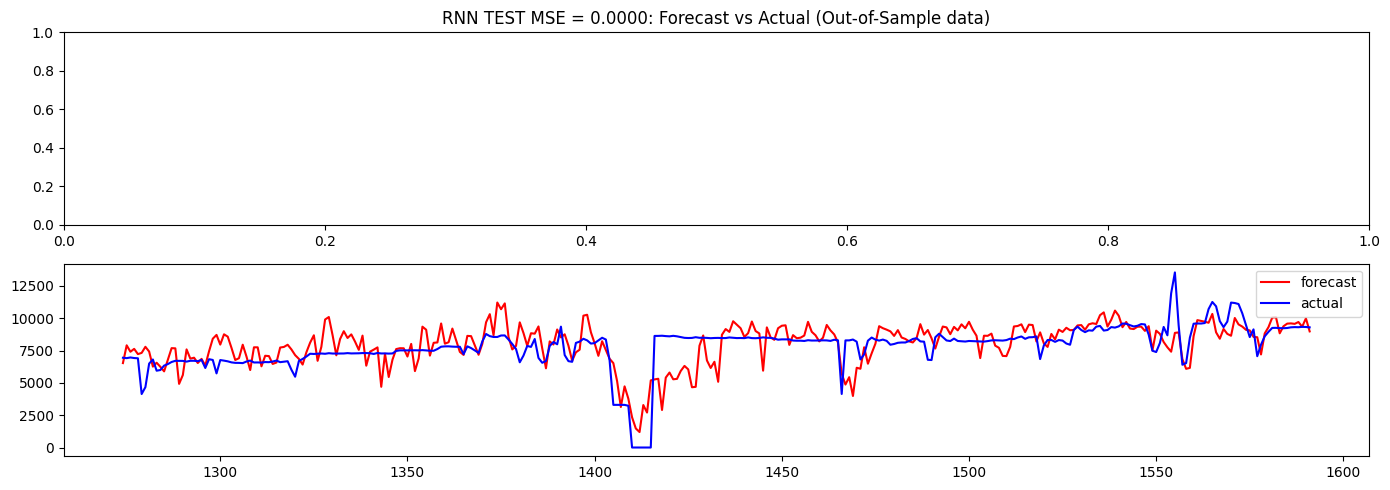

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


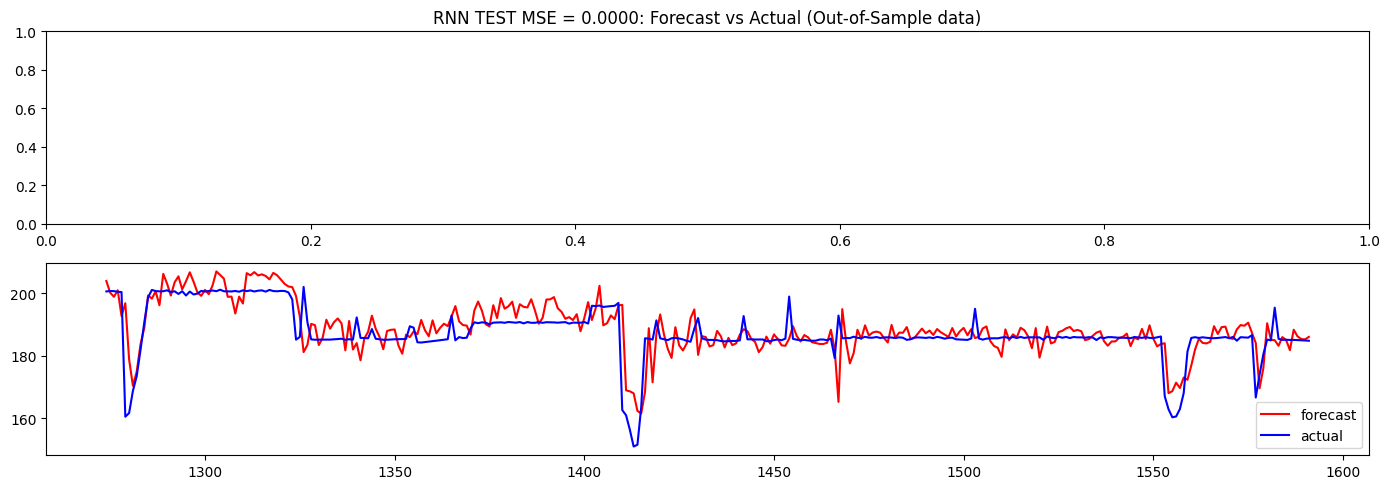

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


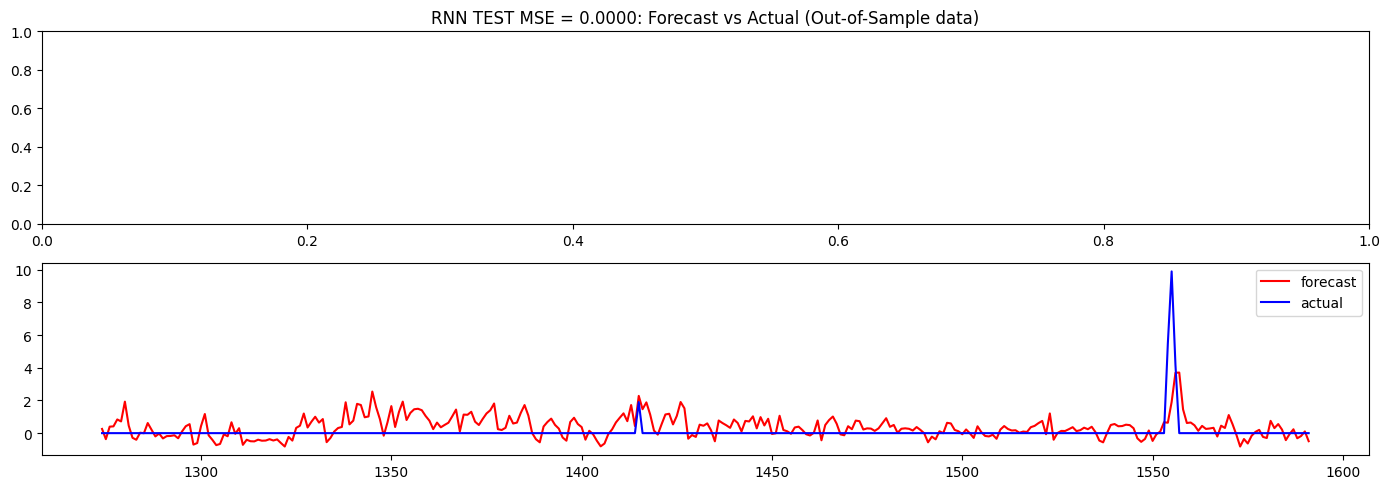

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


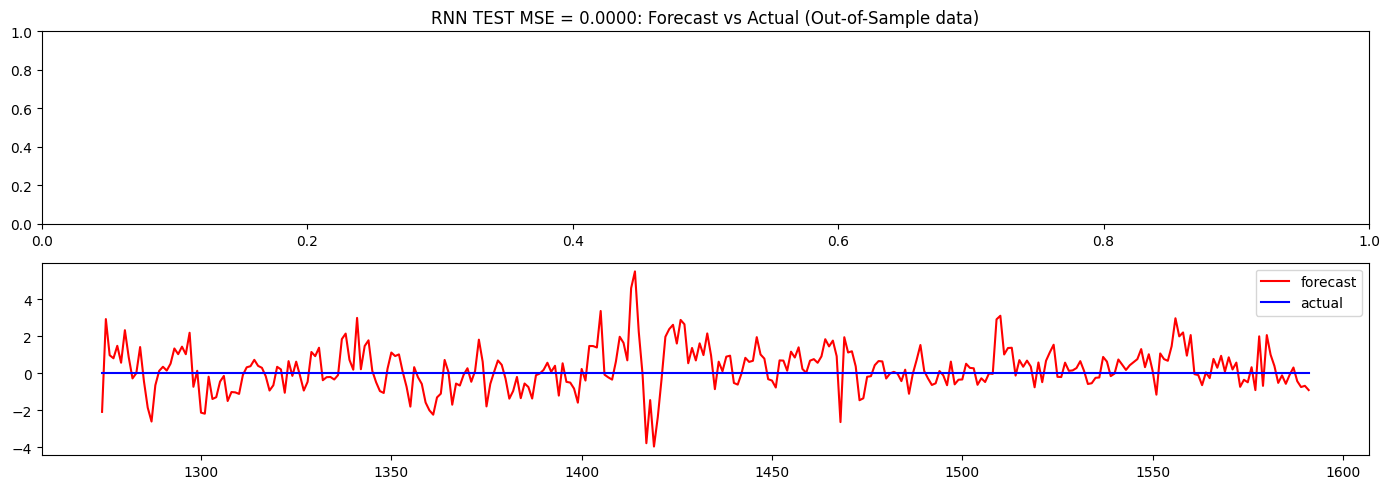

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


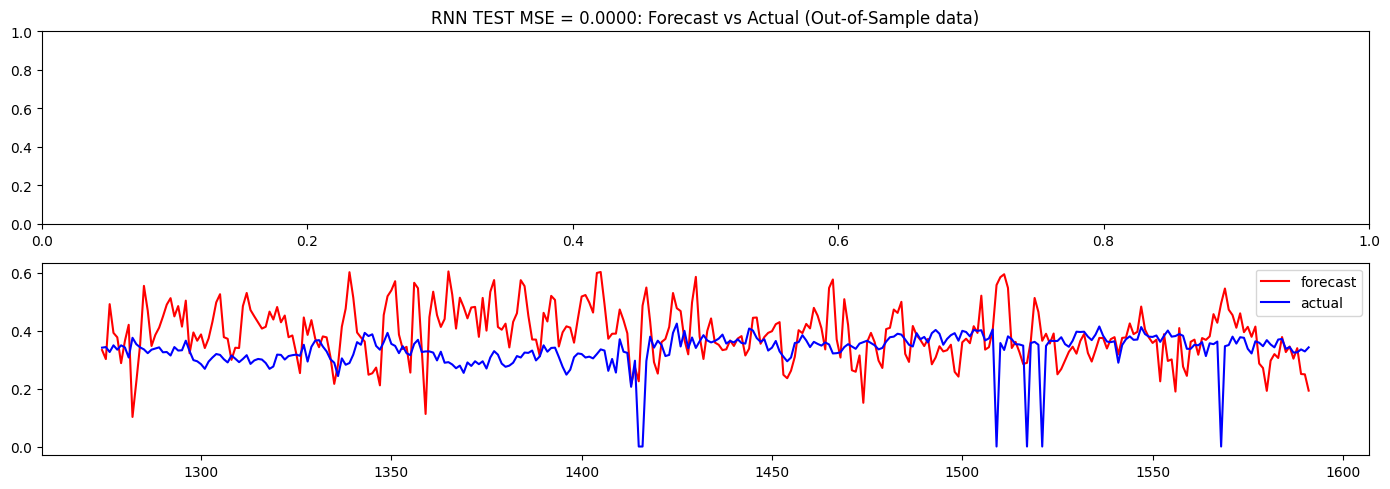

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


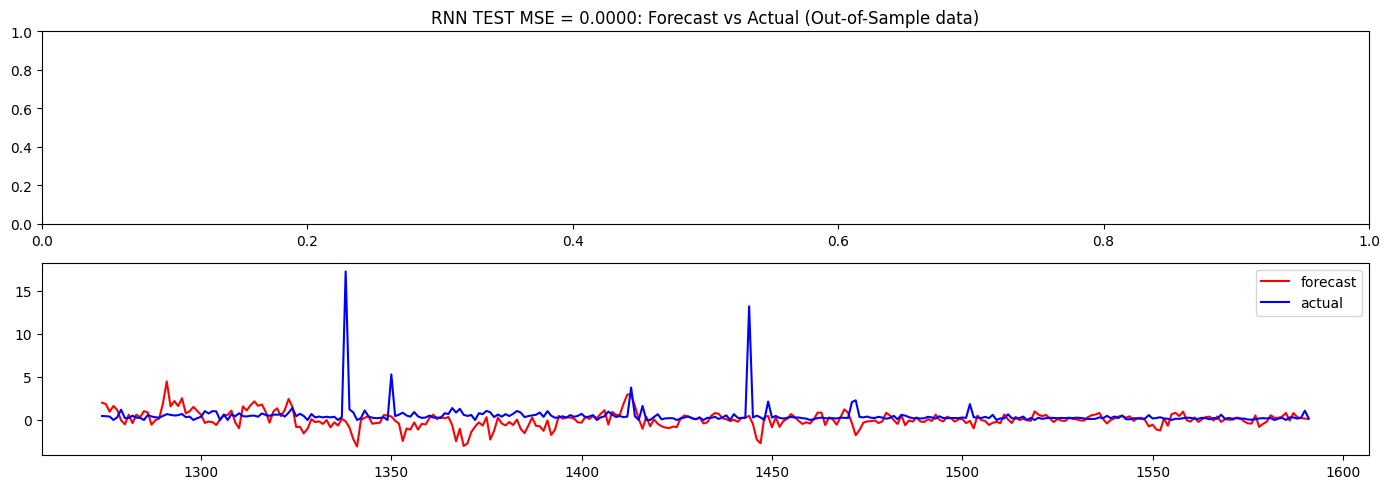

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


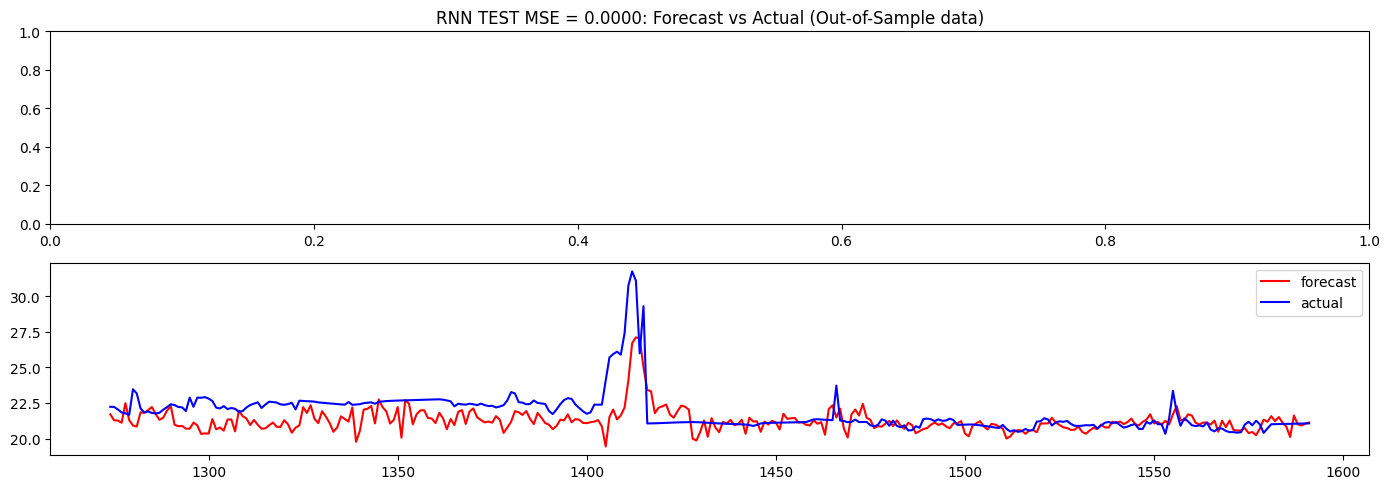

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


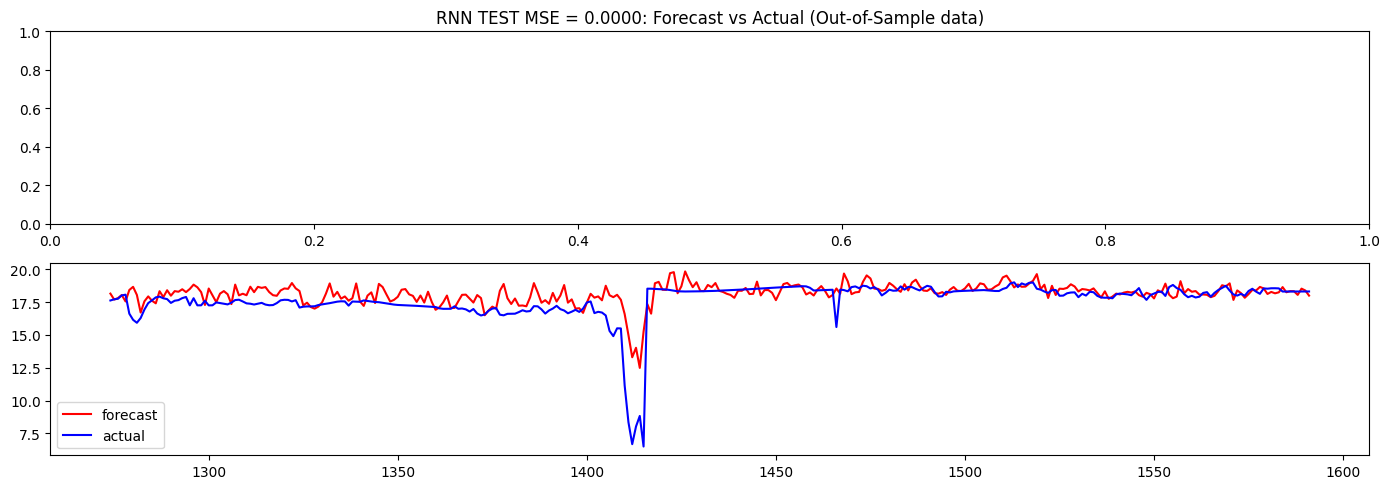

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


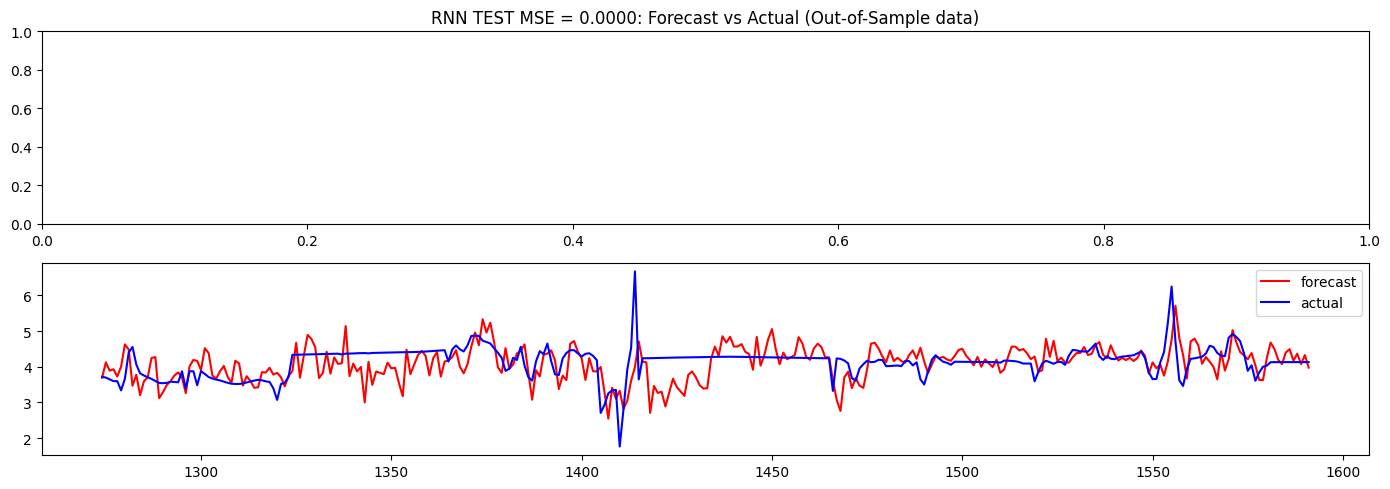

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


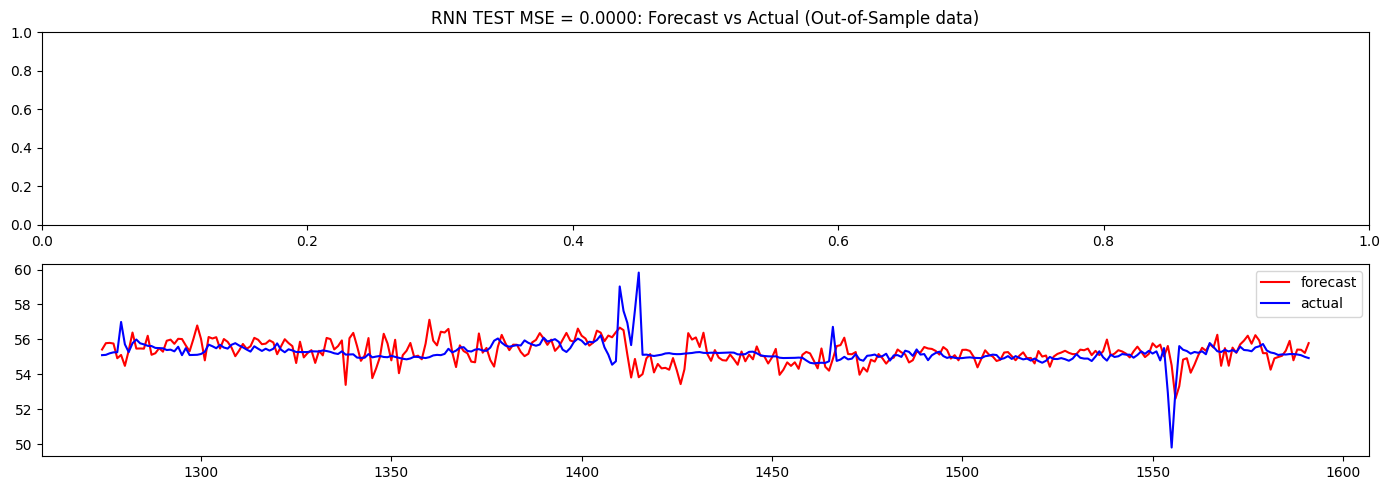

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


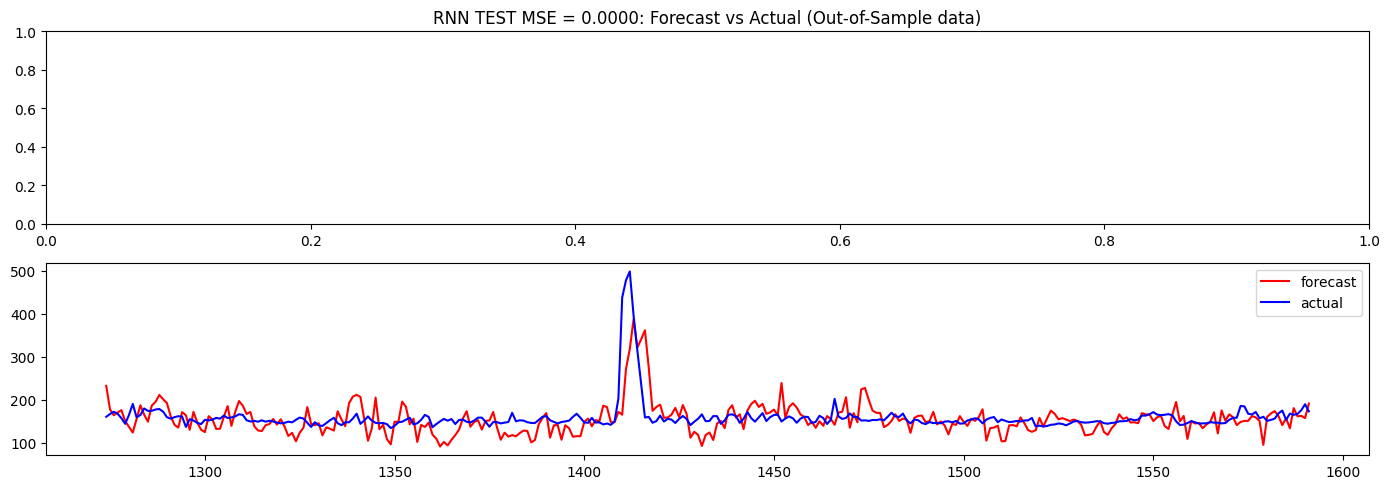

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


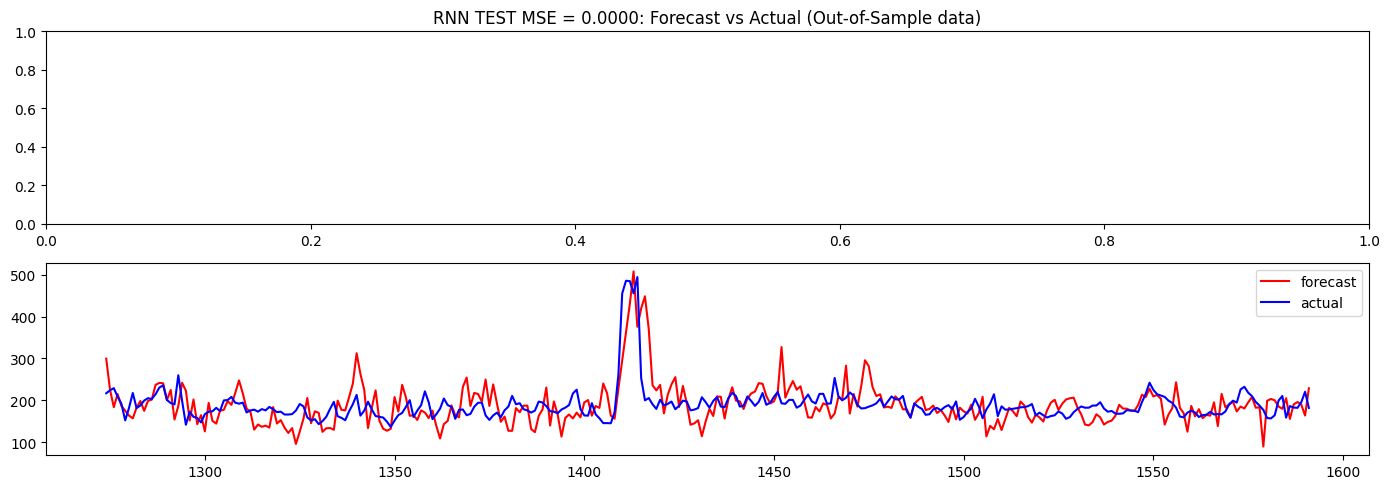

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


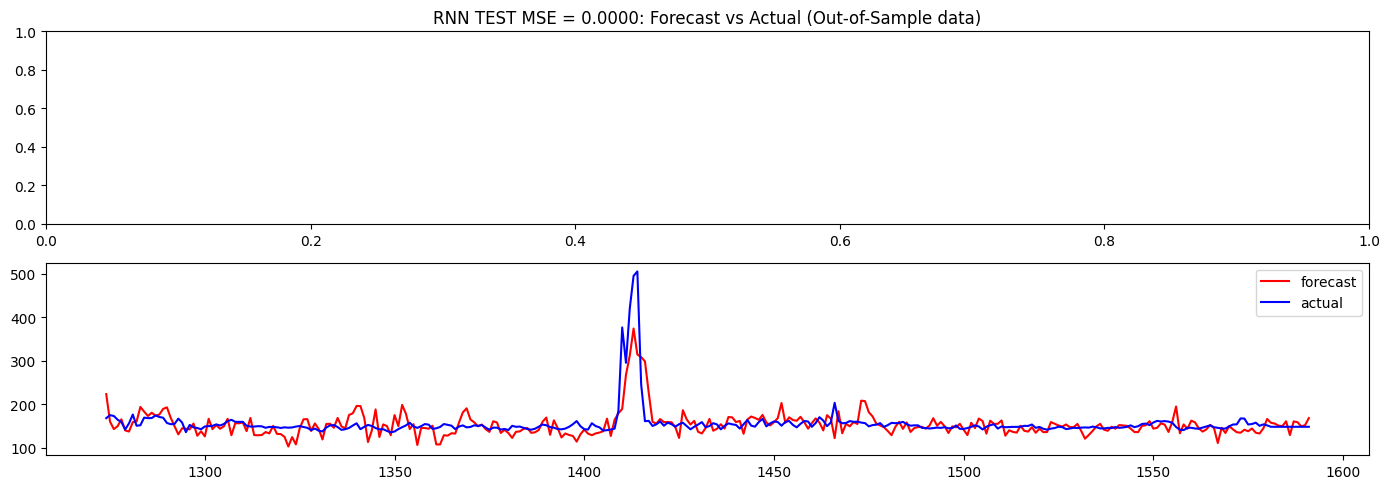

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


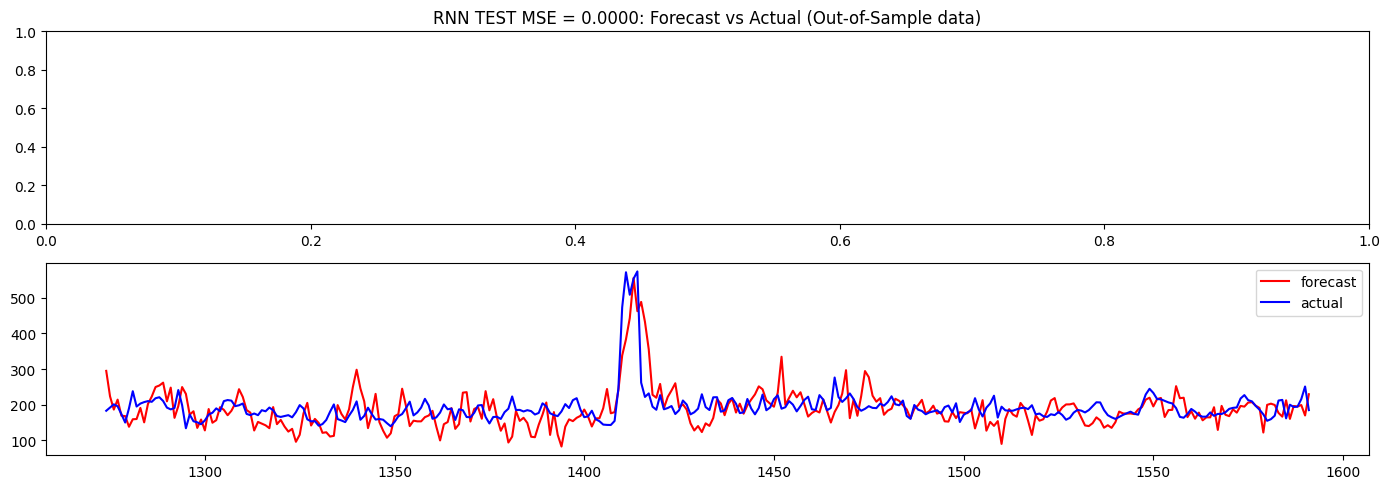

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


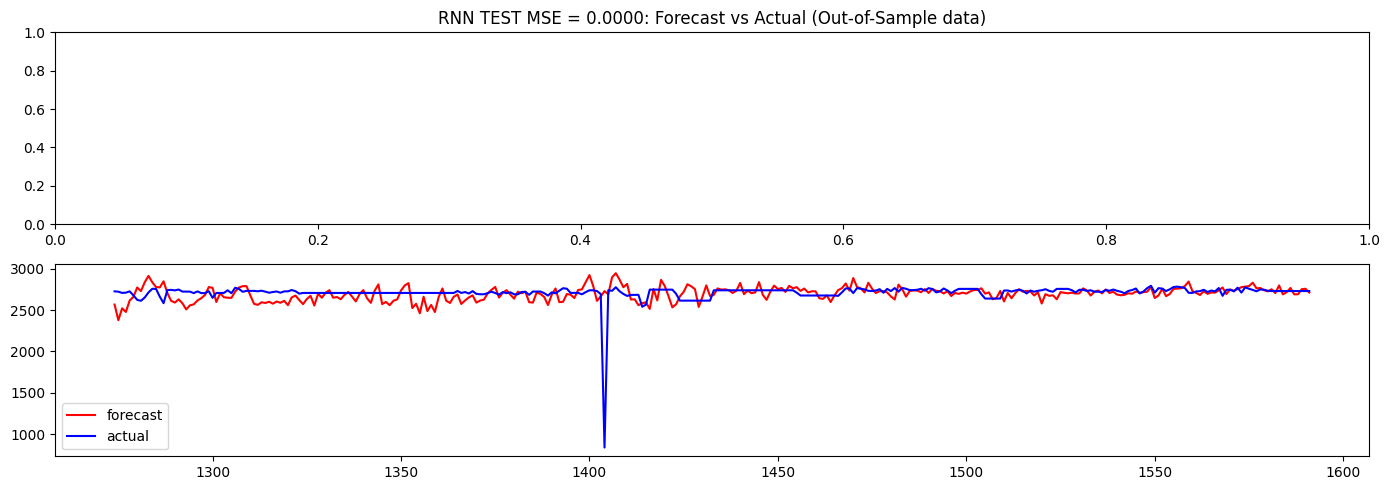

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


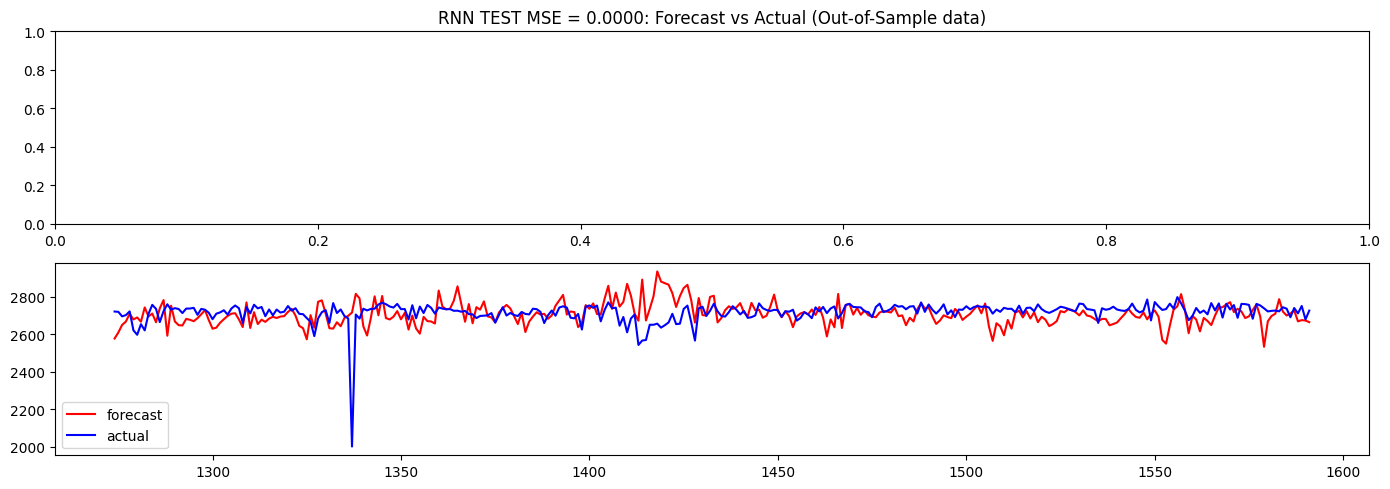

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


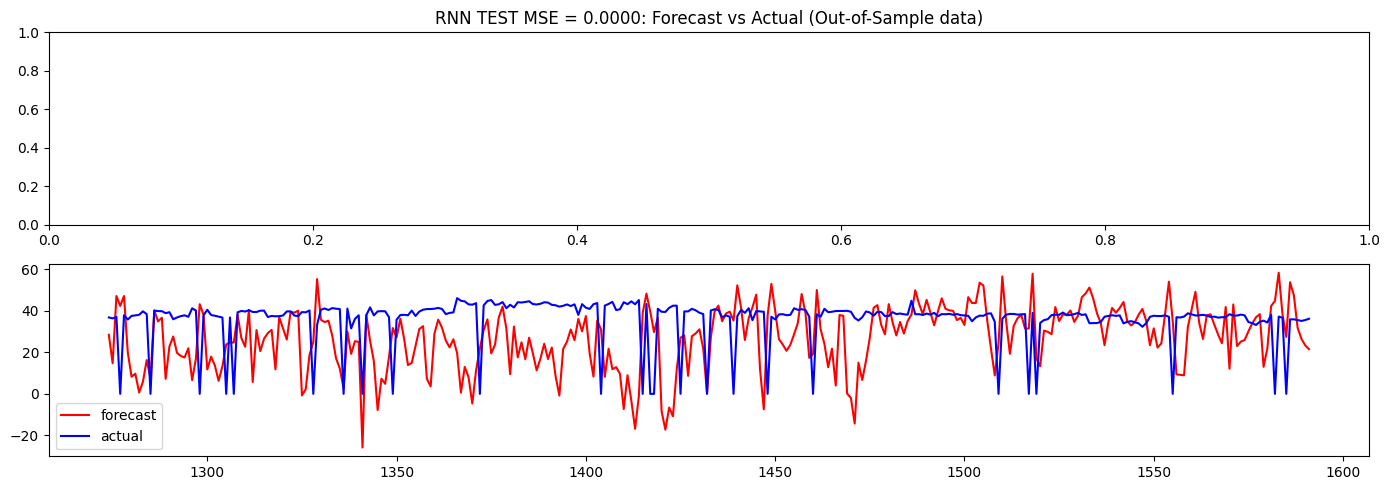

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


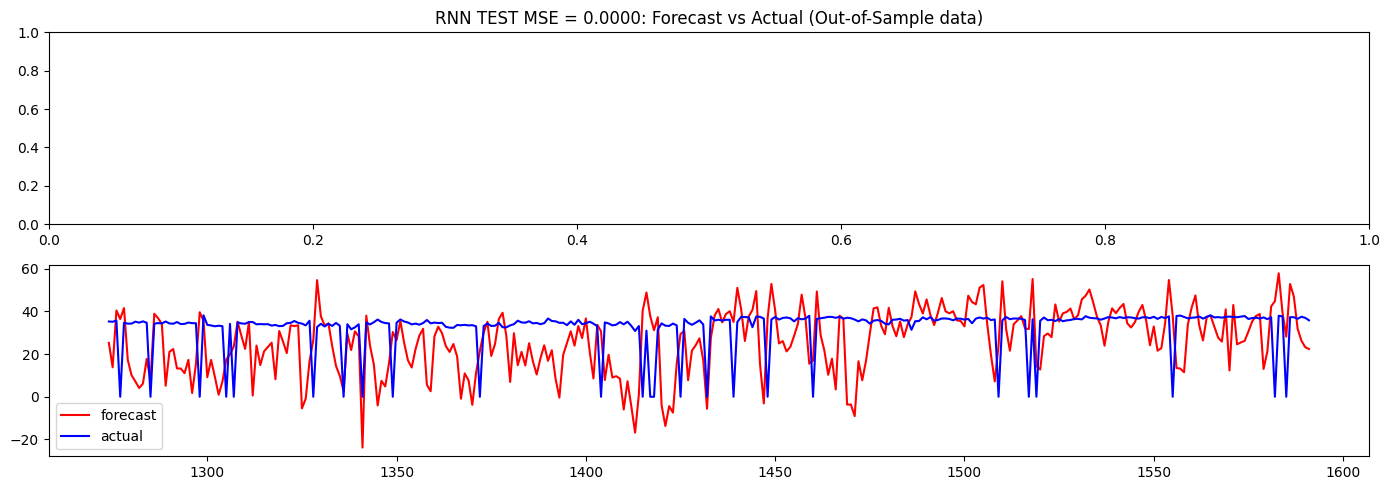

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


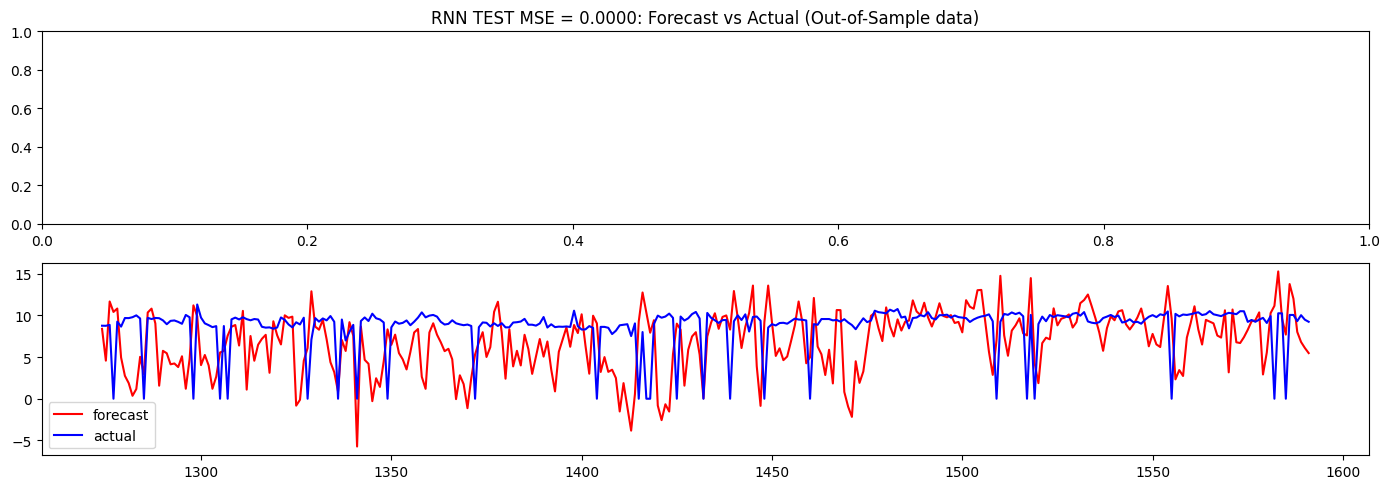

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


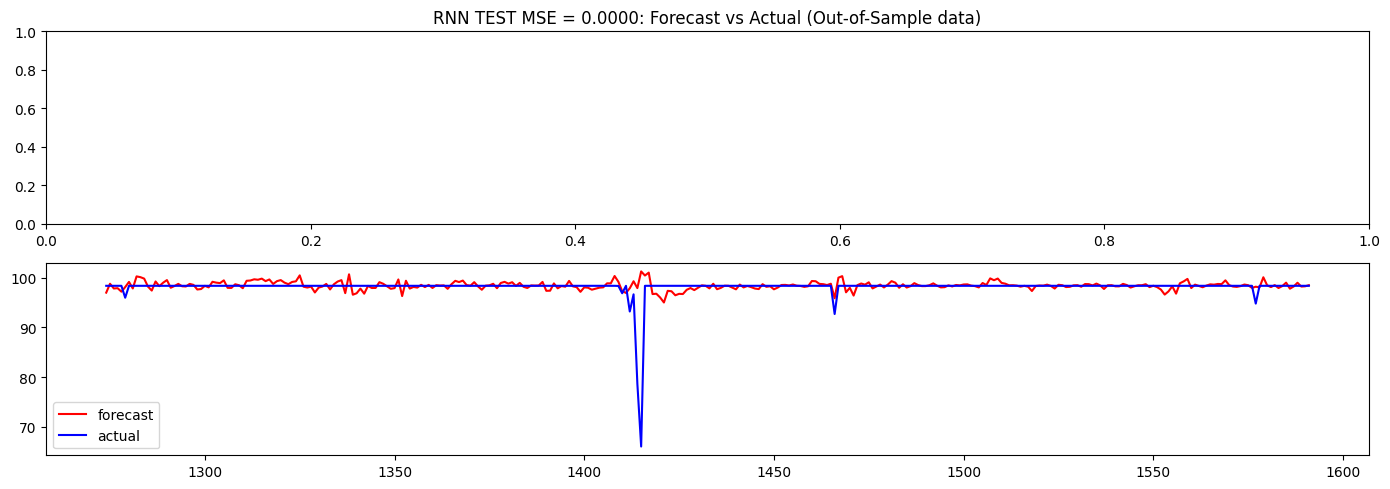

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


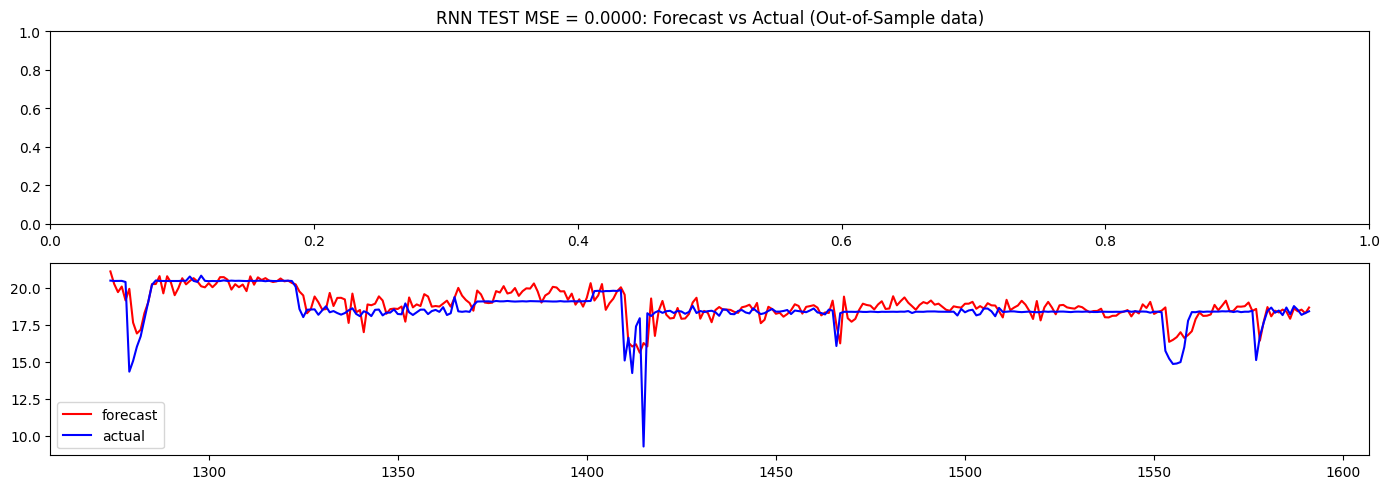

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


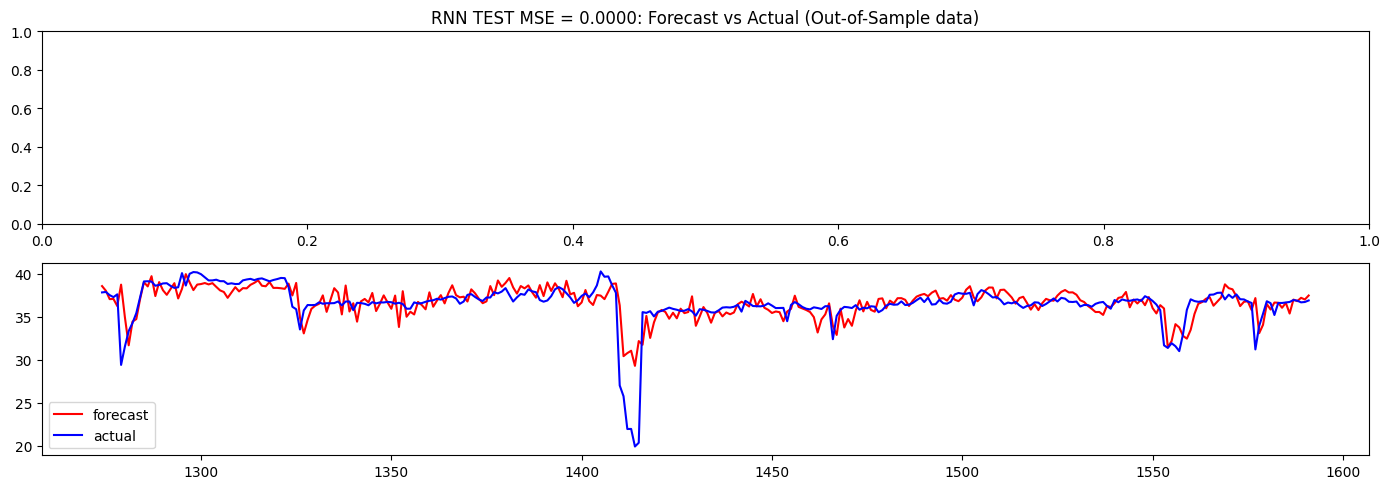

ricardo check this
torch.Size([318, 26])
torch.Size([318, 26])
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(104,)
(104,)
(26,)
(26,)
(318, 26)
(1, 26)
(1, 26)
(318, 26)
(318, 26)


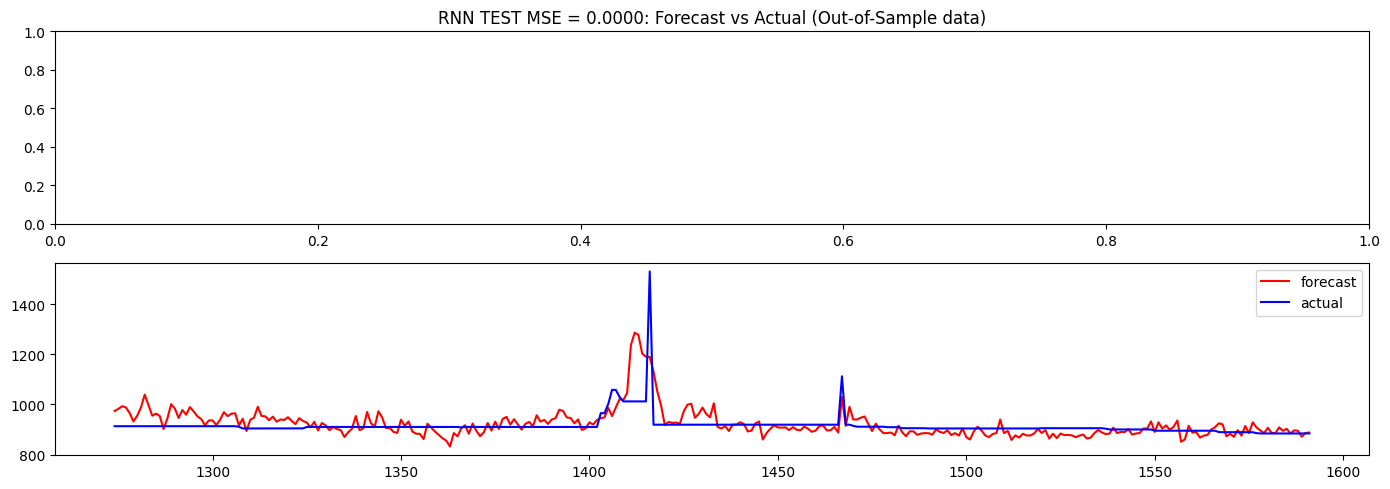

In [112]:

for i in range(26):

    x_index = i

    l1, l2 = View_all_predicted_Xs(x_index, model, model_type='RNN', **params_si )            
